# Setup

To use this notebook, you will need Python 2.7 and the following packages.

 - TensorFlow
 - Keras
 - [GewitterGefahr](https://github.com/thunderhoser/GewitterGefahr)
 - [GeneralExam](https://github.com/thunderhoser/GeneralExam)
 - [SHARPpy](https://github.com/sharppy/SHARPpy)

Instructions for installing Keras and TensorFlow can be found [here](https://keras.io/#installation).  The following procedure shows you how to install GewitterGefahr.  The procedure for installing GeneralExam and SHARPpy is the same -- you just have to change the repository name.  `PACKAGE_DIR_NAME` is the name of the directory to which you are installing the packages.  Each package will be installed into a subdirectory of `PACKAGE_DIR_NAME`.  This is done automatically by the `git clone` command.  `PYTHON_EXE_NAME` is the name of the Python executable and dictates the Python environment into which the package will be installed.  For example, mine is `/home/ryan.lagerquist/anaconda2/bin/python2.7`.

1. Open a Unix terminal.  (I'm assuming that you have Linux or Mac.  There are ways to do this in Windows, but I provide absolutely no support for Windows.)
2. `cd $PACKAGE_DIR_NAME`
3. `git clone https://github.com/thunderhoser/GewitterGefahr`
4. `cd gewittergefahr`
5. `$PYTHON_EXE_NAME setup.py install`

The `setup.py` files for GewitterGefahr, GeneralExam, and SHARPpy should automatically install libraries on which they depend (this is done when you enter `$PYTHON_EXE_NAME setup.py install`).  However, the `basemap` library usually does not cooperate.  If you get an error message for `basemap`, use the following procedure to install it manually.  `GEOS_INSTALL_DIR_NAME` is the name of the directory to which you are installing `geos` (a library on which `basemap` depends).

1. Open the Unix terminal again.
2. `cd $PACKAGE_DIR_NAME`
3. `git clone https://github.com/matplotlib/basemap`
4. `cd basemap-1.1.0/geos-3.3.3`
5. `export GEOS_DIR=$GEOS_INSTALL_DIR_NAME`
6. `./configure --prefix=$GEOS_DIR`
7. `make; make install`
8. `cd ..  # Go back to the main basemap directory.`
9. `$PYTHON_EXE_NAME setup.py install`

# Background

This notebook uses deep learning to identify warm and cold fronts in weather grids.  The predictors are spatial grids (images) of wind velocity ($u$ is the eastward component; $v$ is the northward component), temperature, specific humidity, geopotential height, and wet-bulb potential temperature.  These grids come from the North American Regional Reanalysis (NARR) and have 32-km resolution -- in other words, each grid cell is 32 $\times$ 32 km.  Verification data (or "labels" or "ground truth" or "target values") come from Weather Prediction Center (WPC) surface bulletins, which contain warm and cold fronts drawn by human meteorologists.  Both the NARR and WPC data are created every 3 hours (at 0000, 0300, ..., 2100 UTC every day).

The data used in this notebook have undergone a lot of pre-processing (done by the GeneralExam library).  There should soon be a paper in *Weather and Forecasting* on this project, discussing the pre-processing and many other aspects.  When the paper has been accepted we will post a link here.

Our chosen deep-learning model is convolutional neural nets (CNN).  Each input to the CNN is called an "example".  Each example consists of one or more predictor variables, each defined over the same spatial grid, and the target value.  The target value is the label at the center grid cell (the grid dimensions are always odd -- *e.g.*, $65 \times 65$ -- so that there is one grid cell exactly at the center).  This label is 0 if the center grid cell is **not** intersected by a front, 1 if intersected by a warm front, 2 if intersected by a cold front.  Thus, the problem is 3-class classification.  The following notation will be used throughout this notebook, especially in the code.

 - $E$ = number of examkples
 - $M$ = number of rows (latitudes) in each grid
 - $N$ = number of columns (longitudes) in each grid
 - $C$ = number of channels (predictor variables) for each example
 - $K$ = number of target classes = 3 (no front, warm front, and cold front)

# Data

`TODO`: Make the data available online.

# Imports

The following cell imports all third-party code that will be used in this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
"""Code for 2018 AI/ML symposium at University of Oklahoma.

AI/ML = artificial intelligence and machine learning

--- NOTATION ---

The following letters will be used throughout this notebook.

E = number of examples
M = number of spatial rows (latitudes) in grid
N = number of spatial columns (longitudes) in grid
C = number of channels (predictor variables)
K = number of target classes = 3 (no front, warm front, and cold front)
"""

%matplotlib inline
import glob
import random
import os.path
import collections
import numpy
import netCDF4
import keras.layers
import keras.backend as K
import keras.callbacks
import matplotlib.colors
import matplotlib.pyplot as pyplot
from gewittergefahr.gg_utils import time_conversion
from gewittergefahr.gg_utils import model_evaluation as binary_eval
from gewittergefahr.gg_utils import file_system_utils
from gewittergefahr.gg_utils import error_checking
from generalexam.machine_learning import keras_metrics
from generalexam.machine_learning import traditional_cnn
from generalexam.machine_learning import evaluation_utils as eval_utils

/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
Using TensorFlow backend.
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .

# Constants

The following cell defines all the constants used in this notebook

In [2]:
# Input and output directories.
TOP_TRAINING_DIR_NAME = (
    '/localdata/ryan.lagerquist/general_exam/narr_data/'
    'downsized_3d_examples/shuffled/training')
TOP_VALIDATION_DIR_NAME = (
    '/localdata/ryan.lagerquist/general_exam/narr_data/'
    'downsized_3d_examples/shuffled/validation')
TOP_TESTING_DIR_NAME = (
    '/localdata/ryan.lagerquist/general_exam/narr_data/'
    'downsized_3d_examples/testing')
OUTPUT_DIR_NAME = (
    '/localdata/ryan.lagerquist/general_exam/aiml_symposium_notebook')

BEST_MODEL_FILE_NAME = (
    '/localdata/ryan.lagerquist/general_exam/paper_experiment_1000mb/'
    'quick_training/u-wind-grid-relative-m-s01_v-wind-grid-relative-m-s01_'
    'temperature-kelvins_specific-humidity-kg-kg01_init-num-filters=32_'
    'half-image-size-px=16_num-conv-layer-sets=3_dropout=0.50/model.h5'
)

file_system_utils.mkdir_recursive_if_necessary(directory_name=OUTPUT_DIR_NAME)

# These constants help to find input data.
TIME_FORMAT = '%Y%m%d%H'
TIME_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9][0-2][0-9]'
BATCH_NUMBER_REGEX = '[0-9][0-9][0-9][0-9][0-9][0-9][0-9]'
NUM_BATCHES_PER_DIRECTORY = 1000

# Target values.
NO_FRONT_ENUM = 0
WARM_FRONT_ENUM = 1
COLD_FRONT_ENUM = 2

# Valid pooling types.
MAX_POOLING_TYPE_STRING = 'max'
MEAN_POOLING_TYPE_STRING = 'avg'
VALID_POOLING_TYPE_STRINGS = [MAX_POOLING_TYPE_STRING, MEAN_POOLING_TYPE_STRING]

# Valid activation functions.
SIGMOID_FUNCTION_NAME = 'sigmoid'
TANH_FUNCTION_NAME = 'tanh'
RELU_FUNCTION_NAME = 'relu'
SELU_FUNCTION_NAME = 'selu'
ELU_FUNCTION_NAME = 'elu'
LEAKY_RELU_FUNCTION_NAME = 'leaky_relu'
VALID_ACTIVATION_FUNCTION_NAMES = [
    SIGMOID_FUNCTION_NAME, TANH_FUNCTION_NAME, RELU_FUNCTION_NAME,
    SELU_FUNCTION_NAME, ELU_FUNCTION_NAME, LEAKY_RELU_FUNCTION_NAME
]

# Predictor variables.
TEMPERATURE_NAME = 'temperature_kelvins'
HEIGHT_NAME = 'height_m_asl'
SPECIFIC_HUMIDITY_NAME = 'specific_humidity_kg_kg01'
WET_BULB_THETA_NAME = 'wet_bulb_potential_temperature_kelvins'
U_WIND_GRID_RELATIVE_NAME = 'u_wind_grid_relative_m_s01'
V_WIND_GRID_RELATIVE_NAME = 'v_wind_grid_relative_m_s01'

VALID_PREDICTOR_NAMES = [
    TEMPERATURE_NAME, HEIGHT_NAME, SPECIFIC_HUMIDITY_NAME, WET_BULB_THETA_NAME,
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME
]

# Dictionary keys.
PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_MATRIX_KEY = 'target_matrix'
TARGET_TIMES_KEY = 'target_times_unix_sec'
ROW_INDICES_KEY = 'row_indices'
COLUMN_INDICES_KEY = 'column_indices'
PREDICTOR_NAMES_KEY = 'narr_predictor_names'
NARR_MASK_KEY = 'narr_mask_matrix'
PRESSURE_LEVEL_KEY = 'pressure_level_mb'
DILATION_DISTANCE_KEY = 'dilation_distance_metres'

# Constants for plotting.
FIGURE_WIDTH_INCHES = 15
FIGURE_HEIGHT_INCHES = 15

FONT_SIZE = 30
pyplot.rc('font', size=FONT_SIZE)
pyplot.rc('axes', titlesize=FONT_SIZE)
pyplot.rc('axes', labelsize=FONT_SIZE)
pyplot.rc('xtick', labelsize=FONT_SIZE)
pyplot.rc('ytick', labelsize=FONT_SIZE)
pyplot.rc('legend', fontsize=FONT_SIZE)
pyplot.rc('figure', titlesize=FONT_SIZE)

LEVELS_FOR_CSI_CONTOURS = numpy.array(
    [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
LEVELS_FOR_BIAS_CONTOURS = numpy.array([0.25, 0.5, 0.75, 1, 1.5, 2, 3, 5])

# Convolutional kernels.
EDGE_DETECTOR_MATRIX1 = numpy.array([[-1, -1, -1],
                                     [-1, 8, -1],
                                     [-1, -1, -1]], dtype=float)
EDGE_DETECTOR_MATRIX2 = numpy.array([[1, 0, -1],
                                     [0, 0, 0],
                                     [-1, 0, 1]], dtype=float)
EDGE_DETECTOR_MATRIX3 = numpy.array([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]], dtype=float)

# These metrics will be reported during training of a CNN (convolutional neural
# network).
LIST_OF_METRIC_FUNCTIONS = [
    keras_metrics.accuracy, keras_metrics.binary_accuracy,
    keras_metrics.binary_csi, keras_metrics.binary_frequency_bias,
    keras_metrics.binary_pod, keras_metrics.binary_pofd,
    keras_metrics.binary_peirce_score, keras_metrics.binary_success_ratio,
    keras_metrics.binary_focn
]

# Helper Methods

The following cell defines "helper methods" used throughout this notebook.  All the methods are defined as private (with an underscore at the beginning of the name).  Since this is a notebook and not a real Python package, there is no distinction between public and private methods.  However, if I define a method as private (*e.g.*, `_check_predictor_name` rather than `check_predictor_name`), it means that I am trying to draw your attention away from it, because either (a) it performs a very low-level task like error-checking or (b) it performs a very complicated task that is outside the scope of this notebook, which is to learn about deep learning.

In [3]:
def _check_predictor_name(predictor_name):
    """Error-checks name of predictor variable.

    :param predictor_name: Name of predictor variable.
    :raises: ValueError: if name is unrecognized.
    """

    error_checking.assert_is_string(predictor_name)

    if predictor_name not in VALID_PREDICTOR_NAMES:
        error_string = (
            '\n\n{0:s}\nValid predictor names (listed above) do not include '
            '"{1:s}".'
        ).format(str(VALID_PREDICTOR_NAMES), predictor_name)
        raise ValueError(error_string)


def _check_pooling_type(pooling_type_string):
    """Error-checks pooling type.

    :param pooling_type_string: Pooling type ("max" or "avg").
    :raises: ValueError: if pooling type is unrecognized.
    """

    error_checking.assert_is_string(pooling_type_string)

    if pooling_type_string not in VALID_POOLING_TYPE_STRINGS:
        error_string = (
            '\n\n{0:s}\nValid pooling types (listed above) do not include '
            '"{1:s}".'
        ).format(str(VALID_POOLING_TYPE_STRINGS), pooling_type_string)
        raise ValueError(error_string)


def _check_activation_function(function_name):
    """Error-checks activation function.

    :param function_name: Name of activation function.
    :raises: ValueError: if activation function is unrecognized.
    """

    error_checking.assert_is_string(function_name)

    if function_name not in VALID_ACTIVATION_FUNCTION_NAMES:
        error_string = (
            '\n\n{0:s}\nValid activation functions (listed above) do not '
            'include "{1:s}".'
        ).format(str(VALID_ACTIVATION_FUNCTION_NAMES), function_name)
        raise ValueError(error_string)


def _floor_to_nearest(input_value, rounding_base):
    """Rounds number(s) *down* to the nearest multiple of `rounding_base`.

    :param input_value: Scalar or numpy array of real numbers.
    :param rounding_base: Number(s) will be rounded down to the nearest multiple
        of this base.
    :return: output_value: Rounded version of `input_value`.
    """

    if isinstance(input_value, collections.Iterable):
        error_checking.assert_is_real_numpy_array(input_value)
    else:
        error_checking.assert_is_real_number(input_value)

    error_checking.assert_is_greater(rounding_base, 0)
    return rounding_base * numpy.floor(input_value / rounding_base)


def _add_colour_bar(
        axes_object, colour_map_object, values_to_colour, min_colour_value,
        max_colour_value, colour_norm_object=None,
        orientation_string='vertical', extend_min=True, extend_max=True,
        fraction_of_axis_length=0.8, font_size=FONT_SIZE):
    """Adds colour bar to existing axes.

    :param axes_object: Existing axes (instance of
        `matplotlib.axes._subplots.AxesSubplot`).
    :param colour_map_object: Colour scheme (instance of
        `matplotlib.pyplot.cm`).
    :param values_to_colour: numpy array of values to colour.
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :param colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.  If `colour_norm_object is None`,
        will assume that scale is linear.
    :param orientation_string: Orientation of colour bar ("vertical" or
        "horizontal").
    :param extend_min: Boolean flag.  If True, the bottom of the colour bar will
        have an arrow.  If False, it will be a flat line, suggesting that lower
        values are not possible.
    :param extend_max: Same but for top of colour bar.
    :param fraction_of_axis_length: Fraction of axis length (y-axis if
        orientation is "vertical", x-axis if orientation is "horizontal")
        occupied by colour bar.
    :param font_size: Font size for labels on colour bar.
    :return: colour_bar_object: Colour bar (instance of
        `matplotlib.pyplot.colorbar`) created by this method.
    """

    error_checking.assert_is_real_numpy_array(values_to_colour)
    error_checking.assert_is_greater(max_colour_value, min_colour_value)
    error_checking.assert_is_string(orientation_string)
    error_checking.assert_is_boolean(extend_min)
    error_checking.assert_is_boolean(extend_max)
    error_checking.assert_is_greater(fraction_of_axis_length, 0.)
    error_checking.assert_is_leq(fraction_of_axis_length, 1.)

    if colour_norm_object is None:
        colour_norm_object = matplotlib.colors.Normalize(
            vmin=min_colour_value, vmax=max_colour_value, clip=False)

    scalar_mappable_object = pyplot.cm.ScalarMappable(
        cmap=colour_map_object, norm=colour_norm_object)
    scalar_mappable_object.set_array(values_to_colour)

    if extend_min and extend_max:
        extend_string = 'both'
    elif extend_min:
        extend_string = 'min'
    elif extend_max:
        extend_string = 'max'
    else:
        extend_string = 'neither'

    if orientation_string == 'horizontal':
        padding = 0.075
    else:
        padding = 0.05

    colour_bar_object = pyplot.colorbar(
        ax=axes_object, mappable=scalar_mappable_object,
        orientation=orientation_string, pad=padding, extend=extend_string,
        shrink=fraction_of_axis_length)

    colour_bar_object.ax.tick_params(labelsize=font_size)
    return colour_bar_object


def _init_figure_panels(num_rows, num_columns, horizontal_space_fraction=0.1,
                        vertical_space_fraction=0.1):
    """Initializes paneled figure.
    
    :param num_rows: Number of panel rows.
    :param num_columns: Number of panel columns.
    :param horizontal_space_fraction: Horizontal space between panels (as
        fraction of panel size).
    :param vertical_space_fraction: Vertical space between panels (as fraction
        of panel size).
    :return: figure_object: Instance of `matplotlib.figure.Figure`.
    :return: axes_objects_2d_list: 2-D list, where axes_objects_2d_list[i][j] is
        the handle (instance of `matplotlib.axes._subplots.AxesSubplot`) for the
        [i]th row and [j]th column.
    """

    error_checking.assert_is_integer(num_rows)
    error_checking.assert_is_geq(num_rows, 1)
    error_checking.assert_is_integer(num_columns)
    error_checking.assert_is_geq(num_columns, 1)
    error_checking.assert_is_geq(horizontal_space_fraction, 0.)
    error_checking.assert_is_less_than(horizontal_space_fraction, 1.)
    error_checking.assert_is_geq(vertical_space_fraction, 0.)
    error_checking.assert_is_less_than(vertical_space_fraction, 1.)

    figure_object, axes_objects_2d_list = pyplot.subplots(
        num_rows, num_columns, sharex=False, sharey=False,
        figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    if num_rows == num_columns == 1:
        axes_objects_2d_list = [[axes_objects_2d_list]]
    elif num_columns == 1:
        axes_objects_2d_list = [[a] for a in axes_objects_2d_list]
    elif num_rows == 1:
        axes_objects_2d_list = [axes_objects_2d_list]

    pyplot.subplots_adjust(
        left=0.02, bottom=0.02, right=0.98, top=0.95,
        hspace=vertical_space_fraction, wspace=horizontal_space_fraction)

    return figure_object, axes_objects_2d_list

# Training and Testing Data

In this notebook you will see training and testing files.  They have the same basic format (both can be read via `read_input_examples`), but the training data have undergone two additional processing steps.

1. Shuffling.  Each testing file contains data for a continuous portion of the testing period (2017).  The example, the file named `downsized_3d_examples_2017021000-2017021021.nc` contains data for all time steps (0000, 0300, 0600, 0900, 1200, 1500, 1800, and 2100 UTC) on Feb 10 2017.  Conversely, each training file contains 512 examples from random times throughout the training period (1500 UTC 5 Nov 2008 - 2100 UTC 24 Dec 2014).  An average training file contains data from 64 time steps, with 8 examples per time step.  Thus, the data within each training file are more diverse (less correlated) than the data within each testing file.  This is important, because it makes the training process more stable and less prone to overfitting (*i.e.*, being unduly influenced by a small number of highly correlated training examples).

  For example, suppose that you train a model without shuffling, where each batch consists of examples from the same time step.  The labels at each time step (in the WPC bulletins) are created by one human meteorologist, and different meteorologists have different tendencies (ways of defining and drawing fronts).  Since each weight update is based on one batch, each weight update will be based on labels from one human meteorologist, which could allow the model to overfit the tendencies of one human.

2. Downsampling.  In the raw dataset the vast majority of labels are NF (no front), as opposed to WF (warm front) or CF (cold front).  Keep in mind that "label" for each example is based on which type of front, if any, intersects the center grid cell.  In the raw dataset, only 0.27% are intersected by a warm front and 0.78% are intersected by a cold front, so there are 0.27% WF labels and 0.78% CF labels.  The other 98.95% of labels are NF.  In other words, the class distribution is extremely imbalanced.  In cases of extreme imbalance, machine learning tends to perform badly.  The model has very little incentive to predict the minority classes (WF and CF), because these predictions are usually wrong.  Predicting the majority class (NF) is a much safer bet and tends to maximize accuracy (as well as other performance metrics).

  One way to fix this problem is downsampling, where the human intervenes and changes the class distribution.  Training files contain 50% NF, 25% WF, and 25% CF examples.  Thus, an average training file contains 256 NF, 128 WF, and 128 CF examples.  **Testing files are not downsampled**, so on average they contain 98.95% NF, 0.27% WF, and 0.78% CF examples.  Thus, even though the models are trained on downsampled data, they are tested on non-downsampled data, reflecting the class distribution in the overall population.  This is necessary because, if the model is ever deployed in **real-time**, we will not know the answers yet, so we will not be able to downsample.  In other words, when applying the model in real-time, we do not have the benefit of downsampling.
  
  Downsampling leads to severe overprediction on the testing data.  As you will see later, the pre-trained model has a frequency bias of ${\sim}12$ on the testing data, which means that it predicts fronts ${\sim}12{\times}$ more often than they occur.  This overprediction is mitigated by post-processing, which you can read about in the upcoming *Weather and Forecasting* paper (the "object-conversion" procedure).

# Training Files

## Finding a Training File

The following cell defines `find_training_file`, which locates one training file.

In [4]:
def find_training_file(
        top_training_dir_name, batch_number, raise_error_if_missing=True):
    """Locates file with training examples.
    
    :param top_training_dir_name: Name of top-level directory with training
        examples.
    :param batch_number: Desired batch number (integer).
    :param raise_error_if_missing: Boolean flag.  If file is missing and
        `raise_error_if_missing = True`, this method will error out.
    :return: training_file_name: Path to file with training examples.  If file
        is missing and `raise_error_if_missing = False`, this method will just
        return the expected path.
    :raises: ValueError: if file is missing and `raise_error_if_missing = True`.
    """

    error_checking.assert_is_string(top_training_dir_name)
    error_checking.assert_is_integer(batch_number)
    error_checking.assert_is_geq(batch_number, 0)
    error_checking.assert_is_boolean(raise_error_if_missing)

    first_batch_number = int(_floor_to_nearest(
        batch_number, NUM_BATCHES_PER_DIRECTORY))
    last_batch_number = first_batch_number + NUM_BATCHES_PER_DIRECTORY - 1

    downsized_3d_file_name = (
        '{0:s}/batches{1:07d}-{2:07d}/downsized_3d_examples_batch{3:07d}.nc'
    ).format(top_training_dir_name, first_batch_number, last_batch_number,
             batch_number)

    if raise_error_if_missing and not os.path.isfile(downsized_3d_file_name):
        error_string = 'Cannot find file.  Expected at: "{0:s}"'.format(
            downsized_3d_file_name)
        raise ValueError(error_string)

    return downsized_3d_file_name

## Finding Many Training Files

The following cell defines `find_many_training_files`, which, as you might have guessed, finds many training files.

In [5]:
def _file_name_to_batch_number(training_file_name):
    """Parses batch number from file name.

    :param training_file_name: Path to file with training examples.
    :return: batch_number: Integer.
    :raises: ValueError: if batch number cannot be parsed from file name.
    """

    pathless_file_name = os.path.split(training_file_name)[-1]
    extensionless_file_name = os.path.splitext(pathless_file_name)[0]
    return int(extensionless_file_name.split('downsized_3d_examples_batch')[-1])


def find_many_training_files(
        top_training_dir_name, first_batch_number, last_batch_number):
    """Finds many files with training examples.
    
    :param top_training_dir_name: See doc for `find_training_file`.
    :param first_batch_number: First desired batch number (integer).
    :param last_batch_number: Last desired batch number (integer).
    :return: training_file_names: 1-D list of paths to training files.
    :raises: ValueError: if no files are found.
    """

    error_checking.assert_is_string(top_training_dir_name)
    error_checking.assert_is_integer(first_batch_number)
    error_checking.assert_is_integer(last_batch_number)
    error_checking.assert_is_geq(first_batch_number, 0)
    error_checking.assert_is_geq(last_batch_number, first_batch_number)

    downsized_3d_file_pattern = (
        '{0:s}/batches{1:s}-{1:s}/downsized_3d_examples_batch{1:s}.nc'
    ).format(top_training_dir_name, BATCH_NUMBER_REGEX)

    downsized_3d_file_names = glob.glob(downsized_3d_file_pattern)
    if len(downsized_3d_file_names) == 0:
        error_string = 'Cannot find any files with the pattern: "{0:s}"'.format(
            downsized_3d_file_pattern)
        raise ValueError(error_string)

    batch_numbers = numpy.array(
        [_file_name_to_batch_number(f) for f in downsized_3d_file_names],
        dtype=int)
    good_indices = numpy.where(numpy.logical_and(
        batch_numbers >= first_batch_number,
        batch_numbers <= last_batch_number
    ))[0]

    if len(good_indices) == 0:
        error_string = (
            'Cannot find any files with batch number in [{0:d}, {1:d}].'
        ).format(first_batch_number, last_batch_number)
        raise ValueError(error_string)

    downsized_3d_file_names = [downsized_3d_file_names[i] for i in good_indices]
    downsized_3d_file_names.sort()
    return downsized_3d_file_names

## Reading a Training (or Testing) File

The following cell defines `read_input_examples`, which can read either a training or testing file.

In [6]:
def _decrease_grid_size(predictor_matrix, num_half_rows, num_half_columns):
    """Decreases the grid size for each example.
    
    M = original number of rows in grid
    N = original number of columns in grid
    m = new number of rows
    n = new number of columns
    
    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :param num_half_rows: New number of rows will be `2 * num_half_rows + 1`.
        Examples will be cropped so that the center of the original image is the
        center of the new image.  If `num_half_rows is None`, the number of rows
        will not be changed.
    :param num_half_columns: Same but for columns.
    :return: predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    """

    error_checking.assert_is_numpy_array(predictor_matrix, num_dimensions=4)
    num_rows_orig = predictor_matrix.shape[1]
    num_columns_orig = predictor_matrix.shape[2]

    if num_half_rows is not None:
        error_checking.assert_is_integer(num_half_rows)
        error_checking.assert_is_greater(num_half_rows, 0)
        error_checking.assert_is_leq(num_half_rows, (num_rows_orig - 1) / 2)

        center_row_index = (num_rows_orig - 1) / 2
        first_row_index = center_row_index - num_half_rows
        last_row_index = center_row_index + num_half_rows
        predictor_matrix = predictor_matrix[
            :, first_row_index:(last_row_index + 1), ...
        ]

    if num_half_columns is not None:
        error_checking.assert_is_integer(num_half_columns)
        error_checking.assert_is_greater(num_half_columns, 0)
        error_checking.assert_is_leq(
            num_half_columns, (num_columns_orig - 1) / 2)

        center_column_index = (num_columns_orig - 1) / 2
        first_column_index = center_column_index - num_half_columns
        last_column_index = center_column_index + num_half_columns
        predictor_matrix = predictor_matrix[
            :, :, first_column_index:(last_column_index + 1), ...
        ]

    return predictor_matrix


def read_input_examples(
        netcdf_file_name, metadata_only=False, predictor_names_to_keep=None,
        num_half_rows_to_keep=None, num_half_columns_to_keep=None):
    """Reads input examples (training or testing) from NetCDF file.

    :param netcdf_file_name: Path to input file.
    :param metadata_only: Boolean flag.  If True, this method will return only
        metadata (everything except predictor and target matrices).
    :param predictor_names_to_keep: [used if `metadata_only = False`]
        1-D list of predictor variables to return.  Each item must be a string
        accepted by `_check_predictor_name`.  If
        `predictor_names_to_keep is None`, all predictors will be returned, so
        the images will have 6 channels.
    :param num_half_rows_to_keep: [used if `metadata_only = False`]
        Used to decrease the number of rows in each image.  See doc for
        `_decrease_grid_size`.
    :param num_half_columns_to_keep: Same but for columns.
    :return: example_dict: Dictionary with the following keys.
    example_dict['predictor_matrix']: E-by-M-by-N-by-C numpy array of predictor
        variables.  The letters E, M, N, C are defined at the top of this
        notebook.
    example_dict['target_matrix']: E-by-K numpy array of target values.  If
        target_matrix[i, k] = 1, the [i]th example belongs to the [k]th class.
        Class-to-integer encodings are defined with the "ENUM" constants at the
        top of this notebook.
    example_dict['narr_predictor_names']: length-C list with names of predictor
        variables.  The ordering of this list corresponds to the ordering of the
        last axis of "predictor_matrix" (another key in this dictionary).
    example_dict['target_times_unix_sec']: Don't worry about this.
    example_dict['row_indices']: Don't worry about this.
    example_dict['column_indices']: Don't worry about this.
    example_dict['pressure_level_mb']: Don't worry about this.
    example_dict['dilation_distance_metres']: Don't worry about this.
    example_dict['narr_mask_matrix']: Don't worry about this.
    """

    error_checking.assert_is_boolean(metadata_only)
    if metadata_only:
        predictor_names_to_keep = None

    if predictor_names_to_keep is not None:
        error_checking.assert_is_numpy_array(
            numpy.array(predictor_names_to_keep), num_dimensions=1)
        for this_name in predictor_names_to_keep:
            _check_predictor_name(this_name)

    netcdf_dataset = netCDF4.Dataset(netcdf_file_name)

    narr_predictor_names = netCDF4.chartostring(
        netcdf_dataset.variables[PREDICTOR_NAMES_KEY][:])
    narr_predictor_names = [str(s) for s in narr_predictor_names]

    if not metadata_only:
        predictor_matrix = numpy.array(
            netcdf_dataset.variables[PREDICTOR_MATRIX_KEY][:])
        target_matrix = numpy.array(
            netcdf_dataset.variables[TARGET_MATRIX_KEY][:])

        if predictor_names_to_keep is not None:
            these_indices = numpy.array(
                [narr_predictor_names.index(p)
                 for p in predictor_names_to_keep],
                dtype=int)

            predictor_matrix = predictor_matrix[..., these_indices]
            narr_predictor_names = predictor_names_to_keep + []

        predictor_matrix = _decrease_grid_size(
            predictor_matrix=predictor_matrix,
            num_half_rows=num_half_rows_to_keep,
            num_half_columns=num_half_columns_to_keep)

    example_dict = {
        PREDICTOR_NAMES_KEY: narr_predictor_names,
        TARGET_TIMES_KEY: numpy.array(
            netcdf_dataset.variables[TARGET_TIMES_KEY][:], dtype=int),
        ROW_INDICES_KEY: numpy.array(
            netcdf_dataset.variables[ROW_INDICES_KEY][:], dtype=int),
        COLUMN_INDICES_KEY: numpy.array(
            netcdf_dataset.variables[COLUMN_INDICES_KEY][:], dtype=int),
        PRESSURE_LEVEL_KEY: int(getattr(netcdf_dataset, PRESSURE_LEVEL_KEY)),
        DILATION_DISTANCE_KEY: getattr(netcdf_dataset, DILATION_DISTANCE_KEY),
        NARR_MASK_KEY:
            numpy.array(netcdf_dataset.variables[NARR_MASK_KEY][:], dtype=int)
    }

    if not metadata_only:
        example_dict.update({
            PREDICTOR_MATRIX_KEY: predictor_matrix.astype('float32'),
            TARGET_MATRIX_KEY: target_matrix.astype('float64')
        })

    netcdf_dataset.close()
    return example_dict

### Finding a Training File: Example 1

The following cell is an example of using `find_training_file`.  In this case `raise_error_if_missing=False`, so if the file is missing, `find_training_file` will return the **expected** path.  This is useful when you are **writing** a file and want to determine the output location, or when you are reading data and not sure if every desired file exists.  Feel free to play with the input arguments `top_training_dir_name` and `batch_number`.

In [7]:
batch_number = 140010

training_example_file_name = find_training_file(
    top_training_dir_name=TOP_TRAINING_DIR_NAME, batch_number=batch_number,
    raise_error_if_missing=False)
print training_example_file_name

/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140010.nc


### Finding a Training File: Example 2

The following cell is an example of using `find_training_file` with `raise_error_if_missing=True`.  Thus, if the file is missing, `find_training_file` will crash with an error message.  Try changing the input arguments `top_training_dir_name` and `batch_number` to make it crash.

In [8]:
batch_number = 140010

training_example_file_name = find_training_file(
    top_training_dir_name=TOP_TRAINING_DIR_NAME, batch_number=batch_number,
    raise_error_if_missing=True)
print training_example_file_name

/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140010.nc


### Finding Many Training Files: Example

The following cell is an example of using `find_many_training_files`.  If the method does not find any files, it will crash with an error message.  Otherwise, it will exit happily and return paths to the files it has found.  Again, feel free to play with the input arguments.

In [9]:
first_batch_number = 140000
last_batch_number = 150000

training_example_file_names = find_many_training_files(
    top_training_dir_name=TOP_TRAINING_DIR_NAME,
    first_batch_number=first_batch_number,
    last_batch_number=last_batch_number)

for this_file_name in training_example_file_names:
    print this_file_name

/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140000.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140001.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140002.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140003.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140004.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140005.nc
/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batc

### Reading a Training File: Example 1

The following cell is an example of using `read_input_examples`.  In this case `metadata_only=True`, so the method returns only metadata, which do not include the predictors or target values.

The only metadata field that you will actually need to worry about in this notebook, is `narr_predictor_names`, which is a 1-D list with names of predictor variables, in the order that they appear in the predictor matrix.  The other metadata fields are returned only because some methods in the GeneralExam library need them.  Feel free to ignore them.

In [10]:
batch_number = 140010
training_example_file_name = find_training_file(
    top_training_dir_name=TOP_TRAINING_DIR_NAME, batch_number=batch_number,
    raise_error_if_missing=True)
training_example_dict = read_input_examples(
    netcdf_file_name=training_example_file_name, metadata_only=True)

for this_key in training_example_dict:
    print '{0:s} ... {1:s}\n'.format(
        this_key, str(training_example_dict[this_key]))

row_indices ... [200 162 189 236 204  60 210  78 211 161 228 126 199 207 172 109 171  73
 176  78 144  34  85 168 194 110 143  99 244  43 169  55 161 191 146  63
 102 194  89 190  93 218 108  81 118 120 223 130 226 153 180 173 237  51
 177  58 165 109 168 113  81 239  90 148 130 224 153 159 215 166 135  97
 153 216  57 186  51 140 203 235 109  84 157 168 112 204 131 199 117 123
 257 133  81 186 233 137 168 167 152 215  91 132 208 181 149 150 111 194
 200 129 106 146 131 146 216 213 186 129  58 232 226 237 219 123 219 121
 231 146 216 235 245 223 219 243 228 208 120  86  93  86 132 232 136 224
 187 144 138 218 117  41 114 204 191 129  70 219 121 189 134 101 175 124
 153 203 175 221 220  75 166 164 122 166 193 156 171 177  79 190  91 130
 111 208 251 127 158 121 160  68  88 106 205 240 138 231 159 238 157  87
 161 228 138 161 176 163 120 124 156 187  52 144 186 237 167 186 194 122
 139 238 186  57  78  94 142 165 104 131 220 140 191 158 102 157 203  32
 246 161 191 169 126  97 104 160 11

### Reading a Training File: Example 2

The following cell is an example of using `read_input_examples` with `metadata_only=False`.  In this case the method returns metadata, predictor values (images), and target values (labels).  However, we use `predictor_names_to_keep` to subset the predictor variables (image channels).  Each file contains 6 channels, but training a model with 6 channels requires a larger CNN, which increases memory and time requirements, and is more difficult to understand.

At the bottom of this cell, the shapes of the predictor and target matrices are printed.  The shapes should be something like $512 \times 65 \times 65 \times 3$ and $512 \times 3$, indicating that the file contains 512 examples with 65 rows, 65 columns, 3 channels, and 3 target classes.  As we have already discussed, the 3 target classes are NF, WF, and CF.

In [11]:
predictor_names = [
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME,
    WET_BULB_THETA_NAME
]
training_example_dict = read_input_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names)

for this_key in training_example_dict:
    if this_key in [PREDICTOR_MATRIX_KEY, TARGET_MATRIX_KEY]:
        continue

    print '{0:s} ... {1:s}\n'.format(
        this_key, str(training_example_dict[this_key]))

print 'Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape))
print 'Shape of target matrix = {0:s}'.format(
    str(training_example_dict[TARGET_MATRIX_KEY].shape))

row_indices ... [200 162 189 236 204  60 210  78 211 161 228 126 199 207 172 109 171  73
 176  78 144  34  85 168 194 110 143  99 244  43 169  55 161 191 146  63
 102 194  89 190  93 218 108  81 118 120 223 130 226 153 180 173 237  51
 177  58 165 109 168 113  81 239  90 148 130 224 153 159 215 166 135  97
 153 216  57 186  51 140 203 235 109  84 157 168 112 204 131 199 117 123
 257 133  81 186 233 137 168 167 152 215  91 132 208 181 149 150 111 194
 200 129 106 146 131 146 216 213 186 129  58 232 226 237 219 123 219 121
 231 146 216 235 245 223 219 243 228 208 120  86  93  86 132 232 136 224
 187 144 138 218 117  41 114 204 191 129  70 219 121 189 134 101 175 124
 153 203 175 221 220  75 166 164 122 166 193 156 171 177  79 190  91 130
 111 208 251 127 158 121 160  68  88 106 205 240 138 231 159 238 157  87
 161 228 138 161 176 163 120 124 156 187  52 144 186 237 167 186 194 122
 139 238 186  57  78  94 142 165 104 131 220 140 191 158 102 157 203  32
 246 161 191 169 126  97 104 160 11

# Understanding the Target Matrix

The following cell explores the target matrix.  The target matrix is $E \times K$, where $E$ = number of examples and $K$ = number of target classes = 3.  The target matrix is binary, meaning that it contains only zeros and ones.  If `target_matrix[i, k] = 1`, the $i^{\textrm{th}}$ example belongs to the $k^{\textrm{th}}$ classes.  The enumeration is defined at the top of this notebook (search for `ENUM`): 0 for NF, 1 for WF, 2 for CF.

Classes are mutually exclusive and collectively exhaustive, meaning that each example belongs to exactly one class.  This means that the sum across each row of `target_matrix` is 1, as shown in the following cell.  Also, the following cell prints the number of examples in each class.  The numbers should be close to 256 NF examples, 128 WF examples, and 128 CF examples.

In [13]:
target_matrix = training_example_dict[TARGET_MATRIX_KEY]
print 'Target matrix:\n{0:s}\n'.format(str(target_matrix))

row_sums = numpy.sum(training_example_dict[TARGET_MATRIX_KEY], axis=1)
print 'Sum across each row (proves MECE property):\n{0:s}\n'.format(
    str(row_sums))

num_examples_by_class = numpy.sum(
    training_example_dict[TARGET_MATRIX_KEY], axis=0).astype(int)
print (
    'Number of examples with no front = {0:d} ... warm front = {1:d} ... '
    'cold front = {2:d}'
).format(num_examples_by_class[NO_FRONT_ENUM],
         num_examples_by_class[WARM_FRONT_ENUM],
         num_examples_by_class[COLD_FRONT_ENUM])

Target matrix:
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]

Sum across each row (proves MECE property):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

### Reading a Training File: Example 3

The following cell is another example of using `read_input_examples`.  This time, in addition to subsetting predictor variables, we subset the grids.  The full grids are $65 \times 65$, but most of the relevant information is contained near the **center** of each grid, because the task is to predict whether or not a front passes through the **center** grid cell.  Thus, shrinking the grids saves a lot of time and memory, without hurting model performance very much.

Specifically, the following cell shrinks the grids to $33 \times 65$ (33 rows and 65 columns).  The centers of the grids remain the same (they are cropped around the center).

In [14]:
training_example_dict = read_input_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names, num_half_rows_to_keep=16)

print 'Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape))

Shape of predictor matrix = (512, 33, 65, 3)


### Reading a Training File: Example 4

The following cell shrinks the grids to $33 \times 33$ (33 rows and columns).  Again, the center grid cells remain the same, because the grids are cropped around the center.

In [15]:
training_example_dict = read_input_examples(
    netcdf_file_name=training_example_file_name, metadata_only=False,
    predictor_names_to_keep=predictor_names, num_half_rows_to_keep=16,
    num_half_columns_to_keep=16)

print 'Shape of predictor matrix = {0:s}'.format(
    str(training_example_dict[PREDICTOR_MATRIX_KEY].shape))

Shape of predictor matrix = (512, 33, 33, 3)


# Understanding the Predictor Matrix

The following cell explores the predictor matrix.  The original units (before processing) are $\textrm{m s}^{-1}$ (metres per second) for $u$-wind, $\textrm{m s}^{-1}$ for $v$-wind, and K (Kelvins) for wet-bulb potential temperature.  $u$-wind and $v$-wind have typical values of $\left[-20, 20\right]\textrm{ m s}^{-1}$, whereas wet-bulb potential temperature has typical values of $\left[250, 300\right]$ Kelvins.  Thus, the variables have different scales, which is a problem for machine learning.  Machine learning tends to emphasize the variables with the largest scales and de-emphasize those with the smallest scales, so without normalizing, machine learning would emphasize wet-bulb potential temperature and would have difficulty in learning from wind velocity.  Thus, before creating the files, we normalized all variables to the range $\sim\left[0, 1\right]$.

In [16]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
for m in range(len(predictor_names)):
    print (
        'Normalized {0:s} for southwest corner of first example:\n{1:s}\n'
    ).format(predictor_names[m], str(predictor_matrix[0, :5, :5, m]))

    print (
        'Min and max normalized {0:s} over all examples and grid cells = '
        '{1:.4f}, {2:.4f}\n'
    ).format(predictor_names[m],
             numpy.min(predictor_matrix[..., m]),
             numpy.max(predictor_matrix[..., m]))

Normalized u_wind_grid_relative_m_s01 for southwest corner of first example:
[[0.24196863 0.26605898 0.30523247 0.3569148  0.32774496]
 [0.23794751 0.23759818 0.34320495 0.32029295 0.32074326]
 [0.22591798 0.27939707 0.3451827  0.32155976 0.36529818]
 [0.23991723 0.31433287 0.31446236 0.37649396 0.4720375 ]
 [0.2730986  0.2932908  0.3594681  0.4064053  0.4475245 ]]

Min and max normalized u_wind_grid_relative_m_s01 over all examples and grid cells = -0.3902, 1.3044

Normalized v_wind_grid_relative_m_s01 for southwest corner of first example:
[[0.48978397 0.49282187 0.5564813  0.52325314 0.5052187 ]
 [0.4747427  0.4749386  0.49736345 0.51068324 0.51077074]
 [0.53380185 0.4092473  0.3795265  0.52301294 0.49618253]
 [0.4920944  0.48910186 0.4888603  0.41780227 0.49148032]
 [0.4711705  0.47475338 0.45679379 0.43008375 0.4433467 ]]

Min and max normalized v_wind_grid_relative_m_s01 over all examples and grid cells = -0.3601, 1.3126

Normalized wet_bulb_potential_temperature_kelvins for sout

# Plotting Feature Maps

The following method plots a feature map at any stage of processing.  The feature map can be a raw meteorological grid (read directly from a training or testing file via `read_input_examples`) or a feature map produced by convolution, pooling, activation, batch normalization, etc.

In [18]:
def plot_feature_map(
        feature_matrix, axes_object=None, colour_map_object=pyplot.cm.plasma,
        min_colour_value=None, max_colour_value=None):
    """Plots feature map.

    A "feature map" is a spatial grid containing either a raw or transformed
    input variable.  The "raw" variables are the predictors, whose names are
    listed at the top of this notebook.

    :param feature_matrix: Feature map as M-by-N numpy array.
    :param axes_object: Handle for axes on which feature map will be plotted
        (instance of `matplotlib.axes._subplots.AxesSubplot`).  If `axes_object
        is None`, this method will create a new set of axes.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_value: Minimum value in colour map.
    :param max_colour_value: Max value in colour map.
    :return: axes_object: Handle for axes on which feature map was plotted
        (instance of `matplotlib.axes._subplots.AxesSubplot`).
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=2)

    if min_colour_value is None or max_colour_value is None:
        min_colour_value = numpy.percentile(feature_matrix, 1.)
        max_colour_value = numpy.percentile(feature_matrix, 99.)
        if min_colour_value == max_colour_value:
            max_colour_value = min_colour_value + 1e-6

    error_checking.assert_is_greater(max_colour_value, min_colour_value)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    axes_object.pcolormesh(
        feature_matrix, cmap=colour_map_object, vmin=min_colour_value,
        vmax=max_colour_value, shading='flat', edgecolors='None')

    axes_object.set_xlim(0., feature_matrix.shape[1])
    axes_object.set_ylim(0., feature_matrix.shape[0])
    axes_object.set_xticks([])
    axes_object.set_yticks([])

    _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        values_to_colour=feature_matrix, min_colour_value=min_colour_value,
        max_colour_value=max_colour_value)

    return axes_object

# Plotting Wind Fields

# TODO(thunderhoser): maybe get rid of this whole section.

The following method plots a wind field (wind velocity defined over a scalar grid).  Wind velocity is a vector, so a wind field is a vector field (containing both the $u$- and $v$-components at each grid cell), which necessitates a special plotting method.  The following method plots **wind barbs**, which are a standard visualization tool in meteorology.  If you haven't seen wind barbs before, don't worry.  For the purposes of this notebook, you need to understand only two things:

1. At the end of each wind barb are short lines, long lines, and/or flags (chevrons).  In standard meteorological plots, each short line corresponds to 5 kt (nautical miles per hour, where 1 kt = 1.15 mph); each long line corresponds to 10 kt; and each flag corresponds to 50 kt.

  However, in this case the wind fields have already been normalized, so the correspondences are different (0.1 units for a short line, 0.2 units for a long line, 1.0 units for a flag).  Either way, the more "appendages" are attached to a wind barb, the higher the wind speed.

2. The end of the wind barb (the one containing all the "appendages") faces the **direction of origin**.  This is the direction the wind is blowing from, **not** the direction it is blowing towards.

In [19]:
def plot_wind_barbs(
        u_wind_matrix, v_wind_matrix, axes_object=None,
        colour_map_object=pyplot.cm.binary, min_colour_speed=-1.,
        max_colour_speed=0., barb_length=8, empty_barb_radius=0.1):
    """Uses barbs to plot wind field.

    Default input args for `colour_map_object`, `min_colour_speed`, and
    `max_colour_speed` will make all wind barbs black, regardless of their
    speed.

    :param u_wind_matrix: M-by-N numpy array of eastward velocities.
    :param v_wind_matrix: M-by-N numpy array of northward velocities.
    :param axes_object: See doc for `plot_feature_map`.
    :param colour_map_object: Colour map (instance of `matplotlib.pyplot.cm`).
    :param min_colour_speed: Minimum speed (velocity magnitude) in colour map.
    :param max_colour_speed: Max speed in colour map.
    :param barb_length: Length of each wind barb.
    :param empty_barb_radius: Radius for "empty" wind barb (zero speed).
    :return: axes_object: See doc for `plot_feature_map`.
    """

    error_checking.assert_is_numpy_array_without_nan(u_wind_matrix)
    error_checking.assert_is_numpy_array(u_wind_matrix, num_dimensions=2)

    error_checking.assert_is_numpy_array_without_nan(v_wind_matrix)
    error_checking.assert_is_numpy_array(
        v_wind_matrix, exact_dimensions=numpy.array(u_wind_matrix.shape))

    error_checking.assert_is_greater(max_colour_speed, min_colour_speed)
    error_checking.assert_is_geq(max_colour_speed, 0.)

    barb_size_dict = {
        'emptybarb': empty_barb_radius
    }
    barb_increment_dict = {
        'half': 0.1,
        'full': 0.2,
        'flag': 1.
    }

    wind_speed_matrix = numpy.sqrt(u_wind_matrix ** 2 + v_wind_matrix ** 2)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    axes_object.barbs(
        u_wind_matrix, v_wind_matrix, wind_speed_matrix, length=barb_length,
        sizes=barb_size_dict, barb_increments=barb_increment_dict,
        fill_empty=True, rounding=False, cmap=colour_map_object,
        clim=numpy.array([min_colour_speed, max_colour_speed])
    )
    
    return axes_object

# Convolution

The following method performs stand-alone 2-D convolution.  "Stand-alone" means that the convolution is done outside of CNN-training.  "2-D" means that both the input and output images are 2-D.  The input and output images are called "feature maps".  The input images may be either raw data (raw meteorological grids containing, *e.g.*, $u$-wind, $v$-wind, wet-bulb potential temperature, etc.) or feature maps created by another convolution.

In [20]:
def do_2d_convolution(
        feature_matrix, kernel_matrix, pad_edges=False, stride_length_px=1):
    """Convolves 2-D feature maps with 2-D kernel.

    M = number of rows in each feature map
    N = number of columns in each feature map
    C_i = number of input feature maps (channels)

    J = number of rows in kernel
    L = number of columns in kernel
    C_o = number of output feature maps (channels)

    :param feature_matrix: Input feature maps (numpy array).  Dimensions must be
        M x N x C_i or 1 x M x N x C_i.
    :param kernel_matrix: Kernel as numpy array.  Dimensions must be
        J x K x C_i x C_o.
    :param pad_edges: Boolean flag.  If True, edges of each input feature map
        will be zero-padded during convolution, so spatial dimensions of the
        output feature maps will be the same (M x N).  If False, dimensions of
        the output feature maps will be (M - J + 1) x (N - L + 1).
    :param stride_length_px: Stride length (pixels).  The kernel will move by
        this many rows or columns at a time as it slides over each input feature
        map.
    :return: feature_matrix: Output feature maps (numpy array).  Dimensions will
        be 1 x M x N x C_o or 1 x (M - J + 1) x (N - L + 1) x C_o, depending on
        whether or not edges were padded.
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array_without_nan(kernel_matrix)
    error_checking.assert_is_numpy_array(kernel_matrix, num_dimensions=4)
    error_checking.assert_is_boolean(pad_edges)
    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 1)

    if len(feature_matrix.shape) == 3:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)

    if pad_edges:
        padding_string = 'same'
    else:
        padding_string = 'valid'

    feature_tensor = K.conv2d(
        x=K.variable(feature_matrix), kernel=K.variable(kernel_matrix),
        strides=(stride_length_px, stride_length_px), padding=padding_string,
        data_format='channels_last')
    return feature_tensor.eval(session=K.get_session())

# TODO(thunderhoser): keep adding documentation from here.

The next cell explores convolution, one of the basic building blocks of convolutional neural nets (CNN).  In this example we convolve over one predictor variable ("single-channel convolution"), using a random kernel and stride length of 1.  This means that, as the convolutional filter slides over the image (input feature map), it moves one pixel at a time.  Also, we use edge-padding.  This means that, when the filter is near the edge (so that its area of influence includes "ghost pixels," outside the input feature map), the input feature map is padded with zeros.  Later examples will get more complicated.  Feel free to play with num_kernel_rows and num_kernel_columns.

/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:340: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not (numpy.issubdtype(input_variable.dtype, int) or numpy.issubdtype(
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:341: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  input_variable.dtype, float)):


Text(0.5,1,'After convolution')

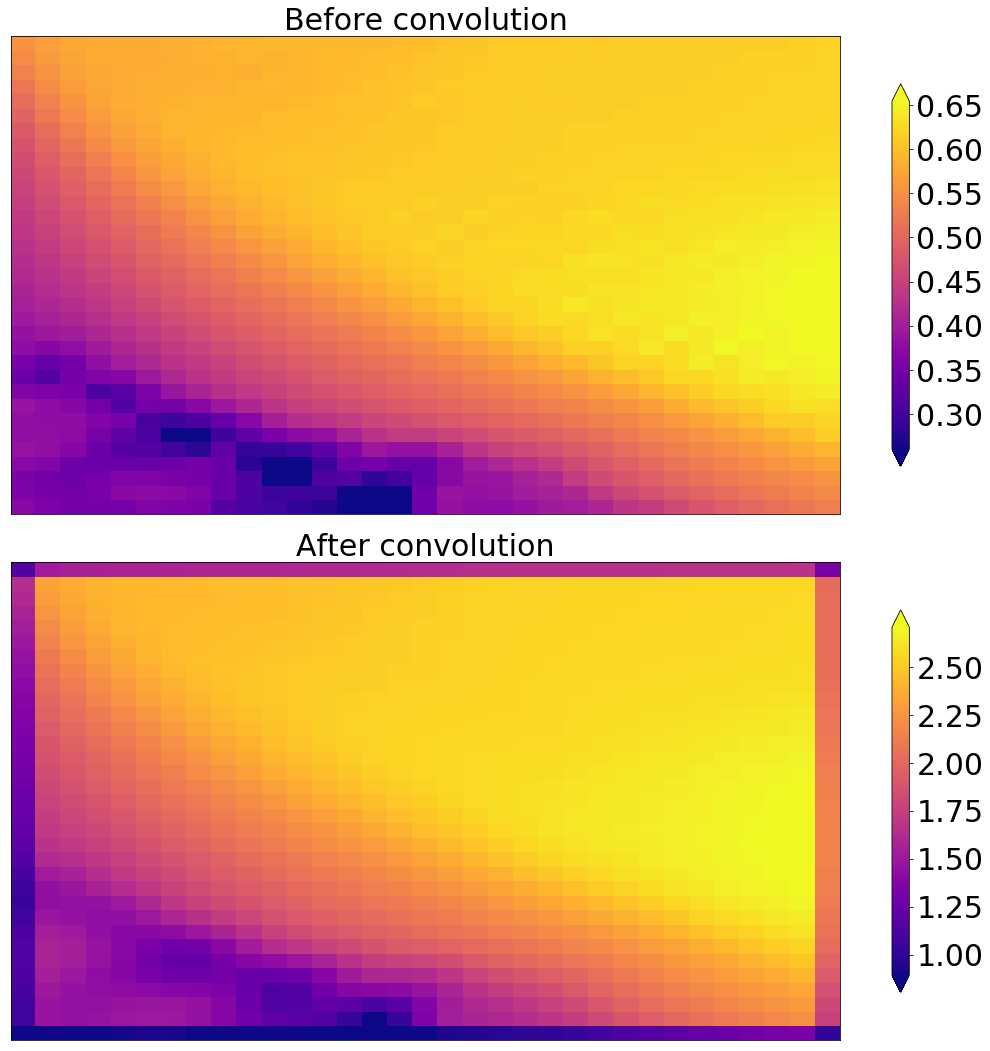

In [19]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1))

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=True, stride_length_px=1)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After convolution')

The next cell does not use edge-padding, which removes artifacts around the edge of the output feature map ("after convolution").

Text(0.5,1,'After convolution')

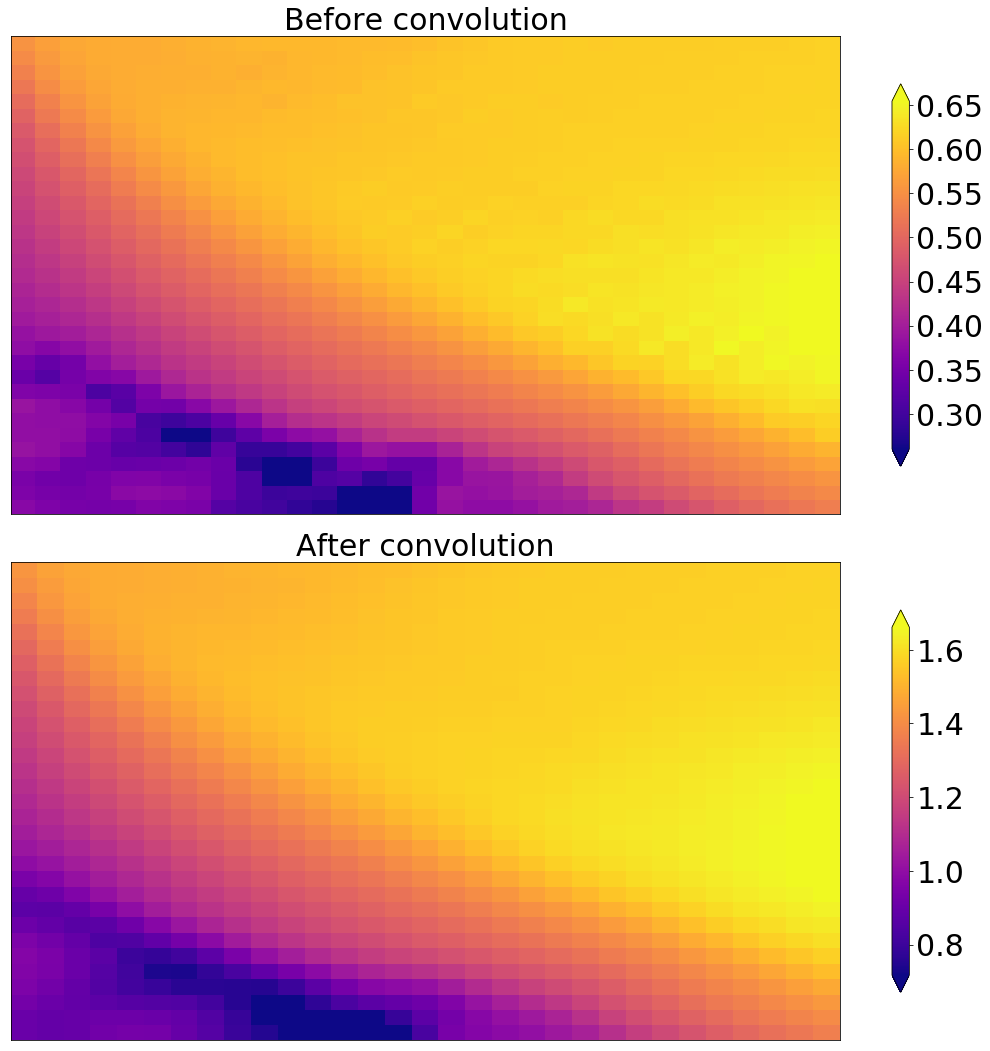

In [185]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1))

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After convolution')

The next cell does "strided convolution," with a stride length of 2 grid cells.  The original grid cells were 32 x 32 km.  The new ones are 64 x 64 km (the grid spacing is multiplied by the stride length).

Text(0.5,1,'After convolution')

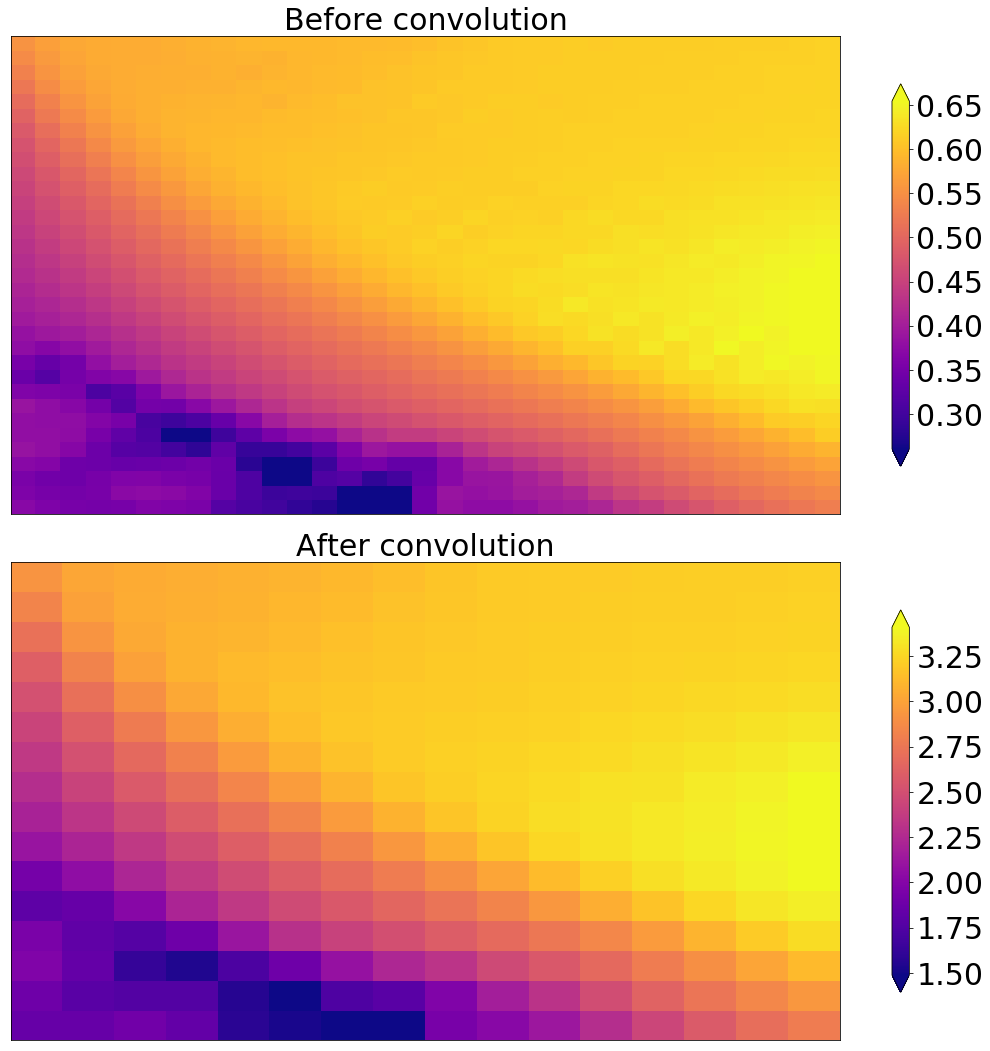

In [186]:
num_kernel_rows = 3
num_kernel_columns = 3

predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.random.uniform(
    low=0., high=1., size=(num_kernel_rows, num_kernel_columns, 1, 1))

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=2)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After convolution')

The next cell does convolution with stride length = 1 and no edge-padding, so it similar to the example two cells above.  The difference is that now the kernel is pre-determined, instead of randomly generated.  The pre-determined kernel is known to be a good edge-detector.

Text(0.5,1,'After convolution')

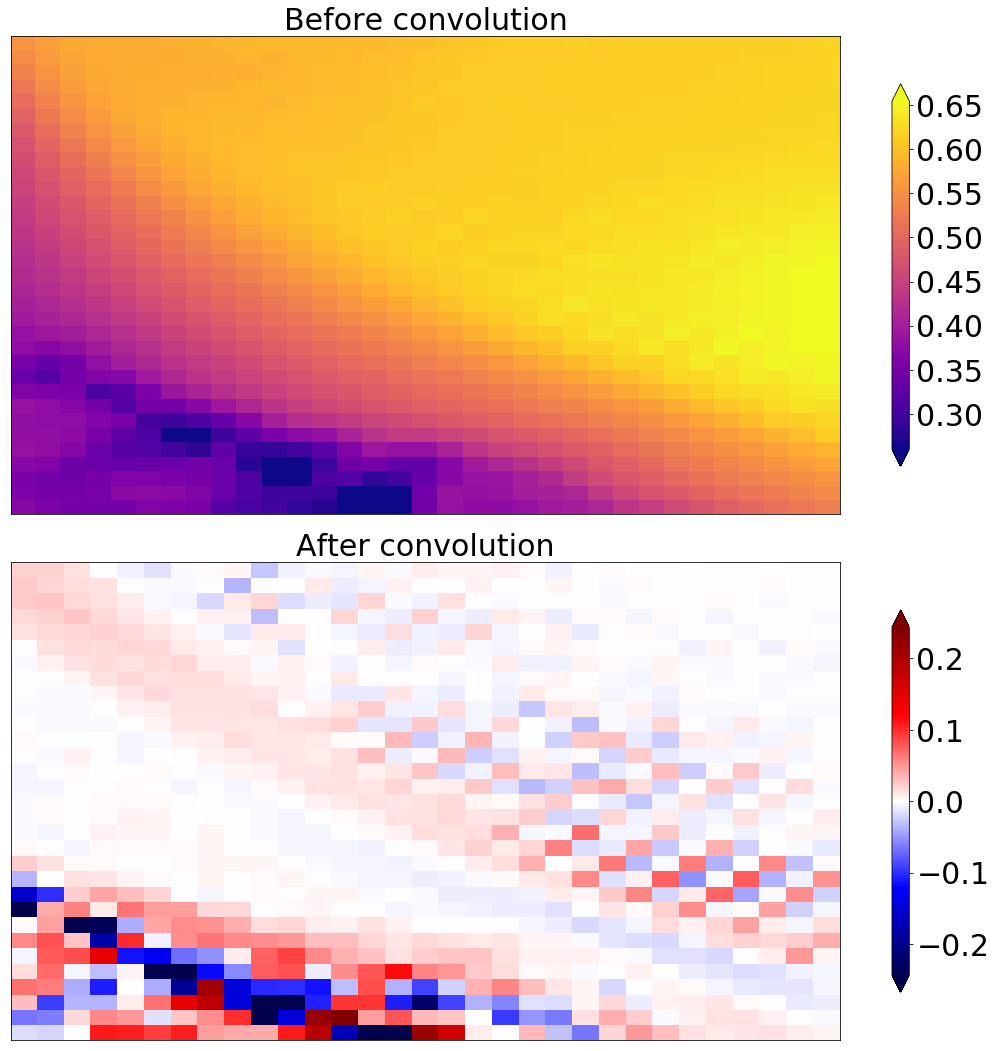

In [187]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][0],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
pyplot.title('After convolution')

The next cell is the same, except that it uses a different edge-detector kernel.

Text(0.5,1,'After convolution')

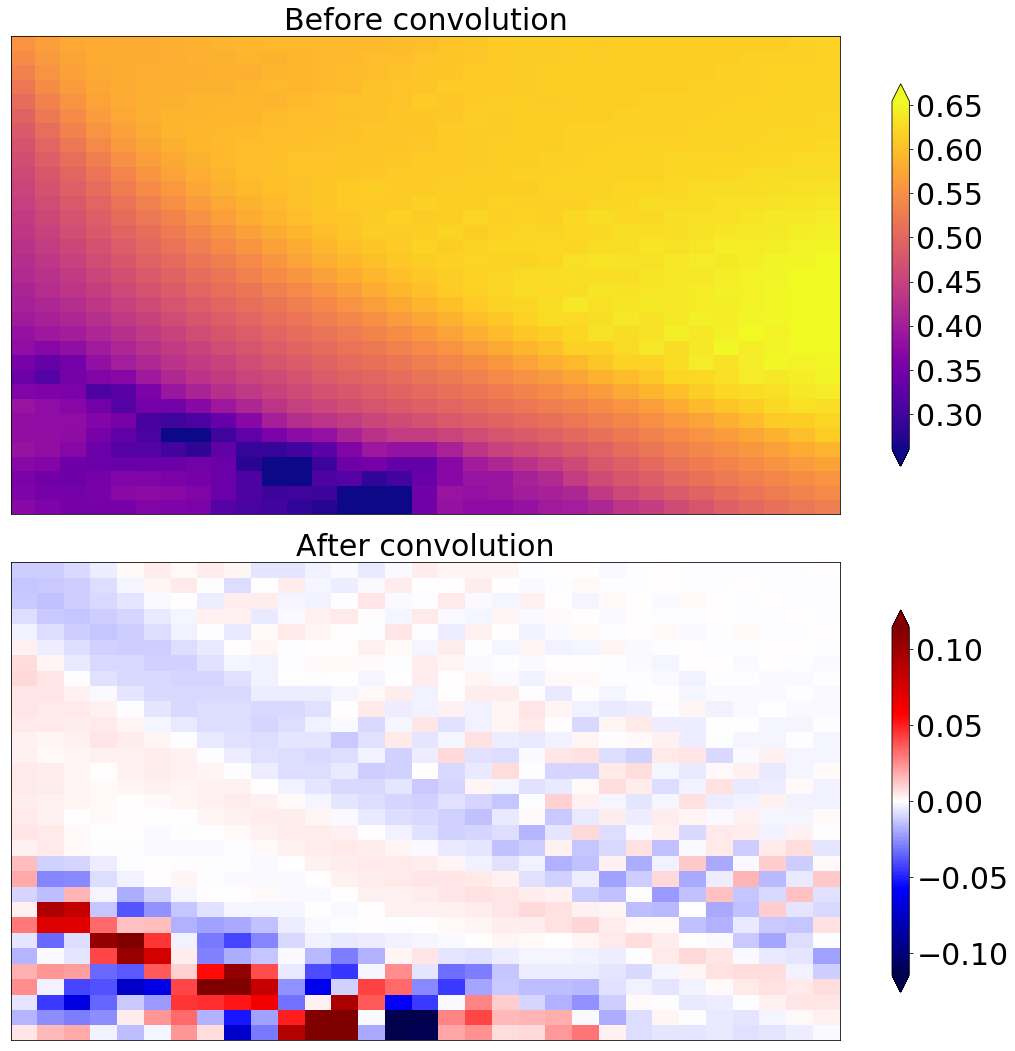

In [188]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX2, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][0],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
pyplot.title('After convolution')

The next cell tries a third edge-detector kernel.

Text(0.5,1,'After convolution')

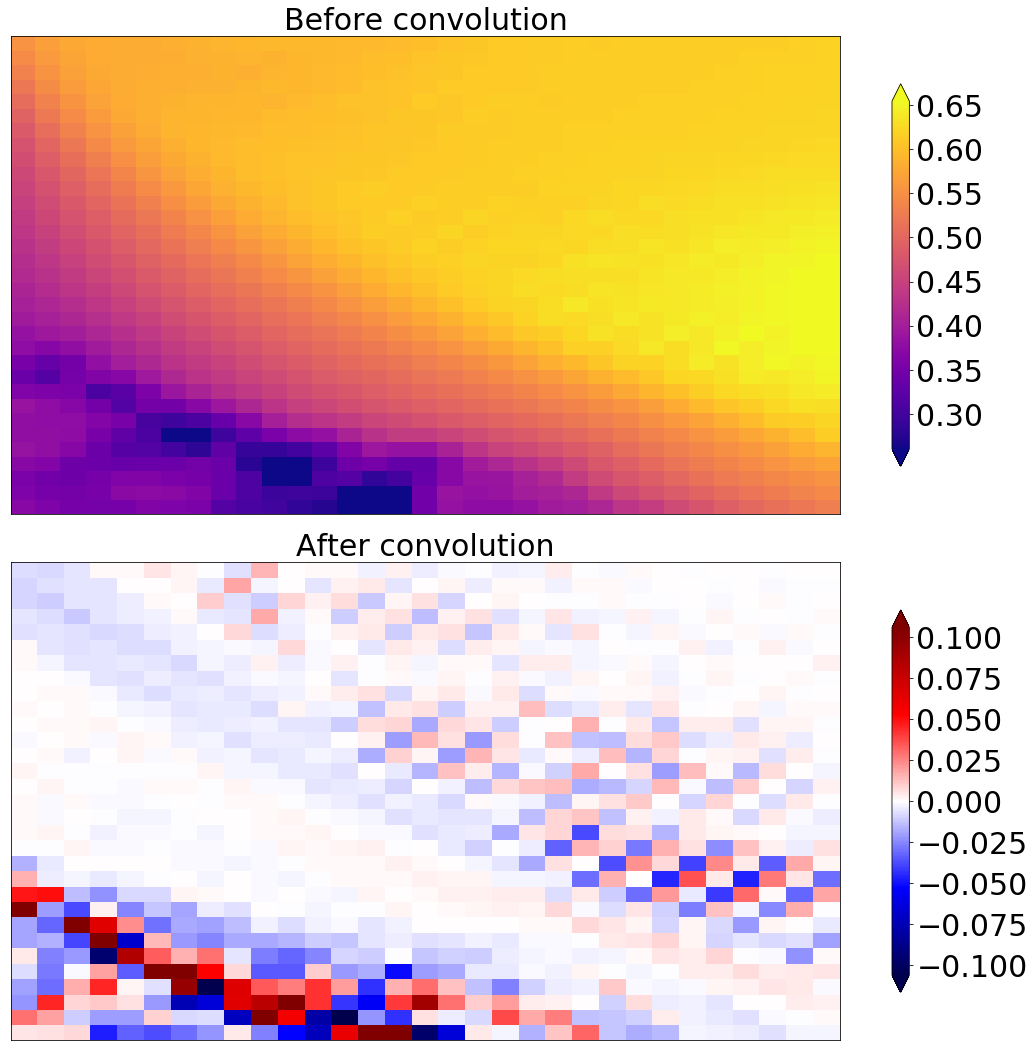

In [189]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX3, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][0],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
pyplot.title('After convolution')

The next cell does multi-channel convolution and requires more explanation.

Text(0.5,1,'Filter 2 after convolution')

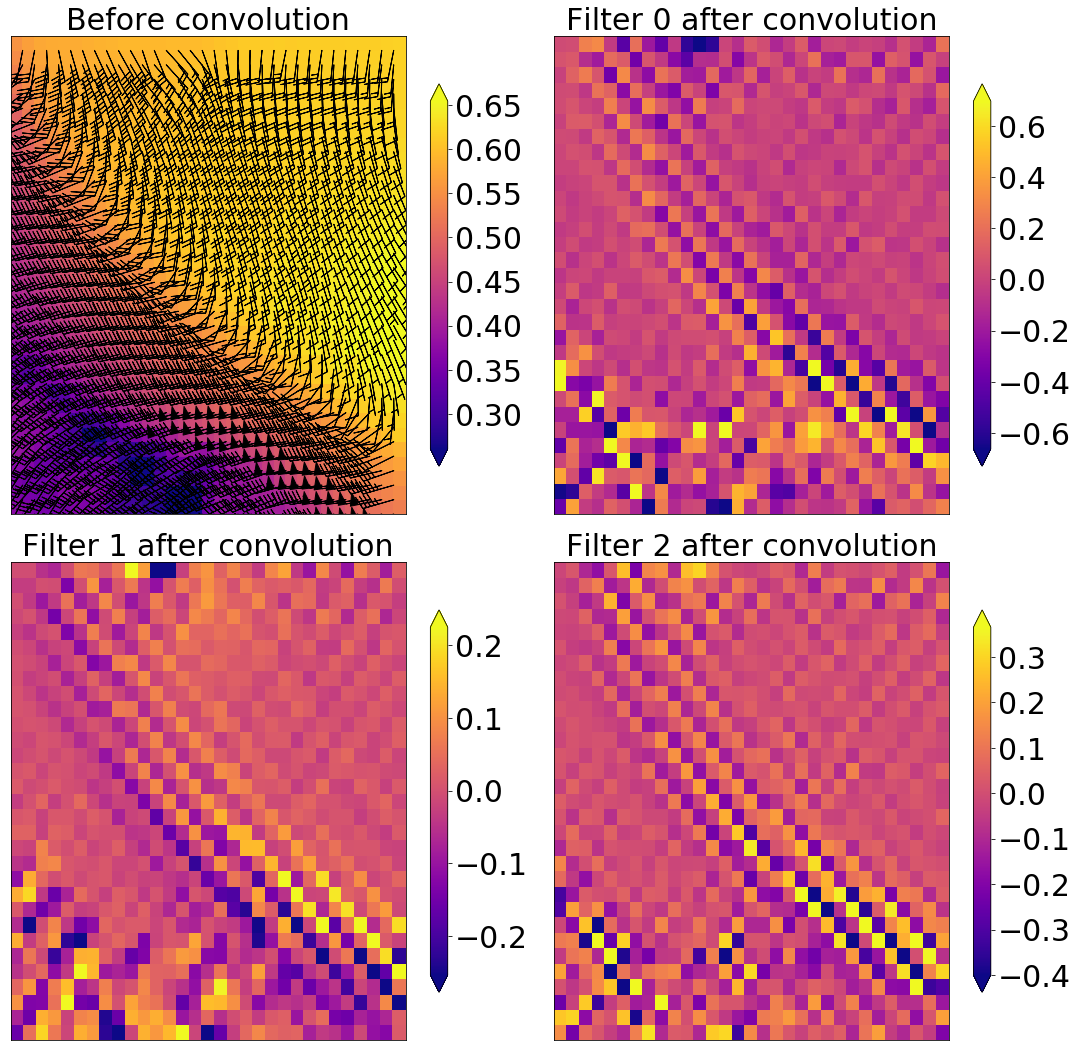

In [190]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
u_wind_index = predictor_names.index(U_WIND_GRID_RELATIVE_NAME)
v_wind_index = predictor_names.index(V_WIND_GRID_RELATIVE_NAME)

wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]
u_wind_matrix = predictor_matrix[0, ..., u_wind_index]
v_wind_matrix = predictor_matrix[0, ..., v_wind_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=2)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
plot_wind_barbs(
    u_wind_matrix=u_wind_matrix, v_wind_matrix=v_wind_matrix,
    axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

kernel_matrix_to_channel0 = numpy.stack(
    (EDGE_DETECTOR_MATRIX1, EDGE_DETECTOR_MATRIX1, EDGE_DETECTOR_MATRIX1),
    axis=-1)
kernel_matrix_to_channel1 = numpy.stack(
    (EDGE_DETECTOR_MATRIX2, EDGE_DETECTOR_MATRIX2, EDGE_DETECTOR_MATRIX2),
    axis=-1)
kernel_matrix_to_channel2 = numpy.stack(
    (EDGE_DETECTOR_MATRIX3, EDGE_DETECTOR_MATRIX3, EDGE_DETECTOR_MATRIX3),
    axis=-1)
kernel_matrix = numpy.stack(
    (kernel_matrix_to_channel0, kernel_matrix_to_channel1,
     kernel_matrix_to_channel2),
    axis=-1)

feature_matrix = numpy.stack(
    (wet_bulb_theta_matrix, u_wind_matrix, v_wind_matrix), axis=-1)
feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[0][1])
axes_objects_2d_list[0][1].set_title('Filter 0 after convolution')

plot_feature_map(feature_matrix=feature_matrix[0, ..., 1],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('Filter 1 after convolution')

plot_feature_map(feature_matrix=feature_matrix[0, ..., 2],
                 axes_object=axes_objects_2d_list[1][1])
axes_objects_2d_list[1][1].set_title('Filter 2 after convolution')

The following method passes an array of input values through an activation function.

In [203]:
def do_activation(input_values, function_name, alpha_parameter=0.2):
    """Runs input array through activation function.

    :param input_values: Input numpy array.
    :param function_name: Name of activation function (must be accepted by
        `_check_activation_function`).
    :param alpha_parameter: Slope (used only for eLU and leaky ReLU functions).
    :return: output_values: Output numpy array (after activation).  Same
        dimensions.
    """

    _check_activation_function(function_name)
    input_object = K.placeholder()

    if function_name == ELU_FUNCTION_NAME:
        function_object = K.function(
            [input_object],
            [keras.layers.ELU(alpha=alpha_parameter)(input_object)]
        )
    elif function_name == LEAKY_RELU_FUNCTION_NAME:
        function_object = K.function(
            [input_object],
            [keras.layers.LeakyReLU(alpha=alpha_parameter)(input_object)]
        )
    else:
        function_object = K.function(
            [input_object],
            [keras.layers.Activation(function_name)(input_object)]
        )

    return function_object([input_values])[0]

The next cell graphs the behaviour of a few standard activation functions.  The basic code for this comes from the Swirlnet tutorial (https://github.com/djgagne/swirlnet/blob/master/notebooks/deep_swirl_tutorial.ipynb) by David John Gagne II, which showcases the use of deep learning to predict mesocyclones in numerically modeled supercell thunderstorms.

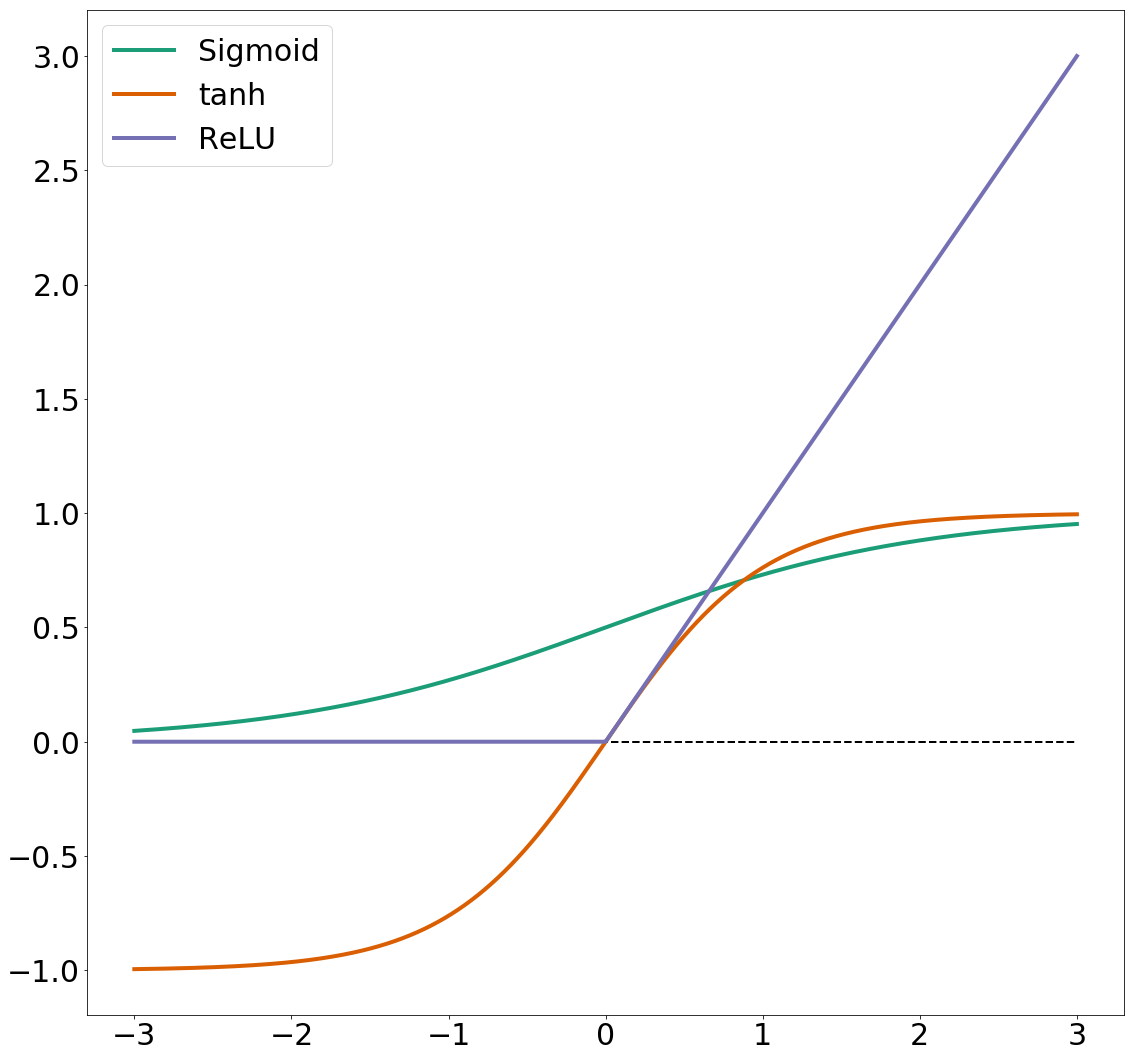

In [204]:
function_names_keras = [
    SIGMOID_FUNCTION_NAME, TANH_FUNCTION_NAME, RELU_FUNCTION_NAME
]
function_names_fancy = ['Sigmoid', 'tanh', 'ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

line_width = 4
colour_by_function = numpy.array([[27, 158, 119],
                                  [217, 95, 2],
                                  [117, 112, 179]], dtype=float) / 255

_, axes_objects_2d_list = _init_figure_panels(num_rows=1, num_columns=1)
axes_object = axes_objects_2d_list[0][0]

axes_object.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=line_width / 2, linestyle='dashed', color=numpy.full(3, 0.))

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i])

    axes_object.plot(
        input_values, these_output_values,
        linewidth=line_width, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i])

axes_object.legend()

The next cell graphs the behaviour of a few fancier activation functions: leaky ReLU (rectified linear unit), eLU (exponential linear unit), and SeLU (scaled exponential linear unit).

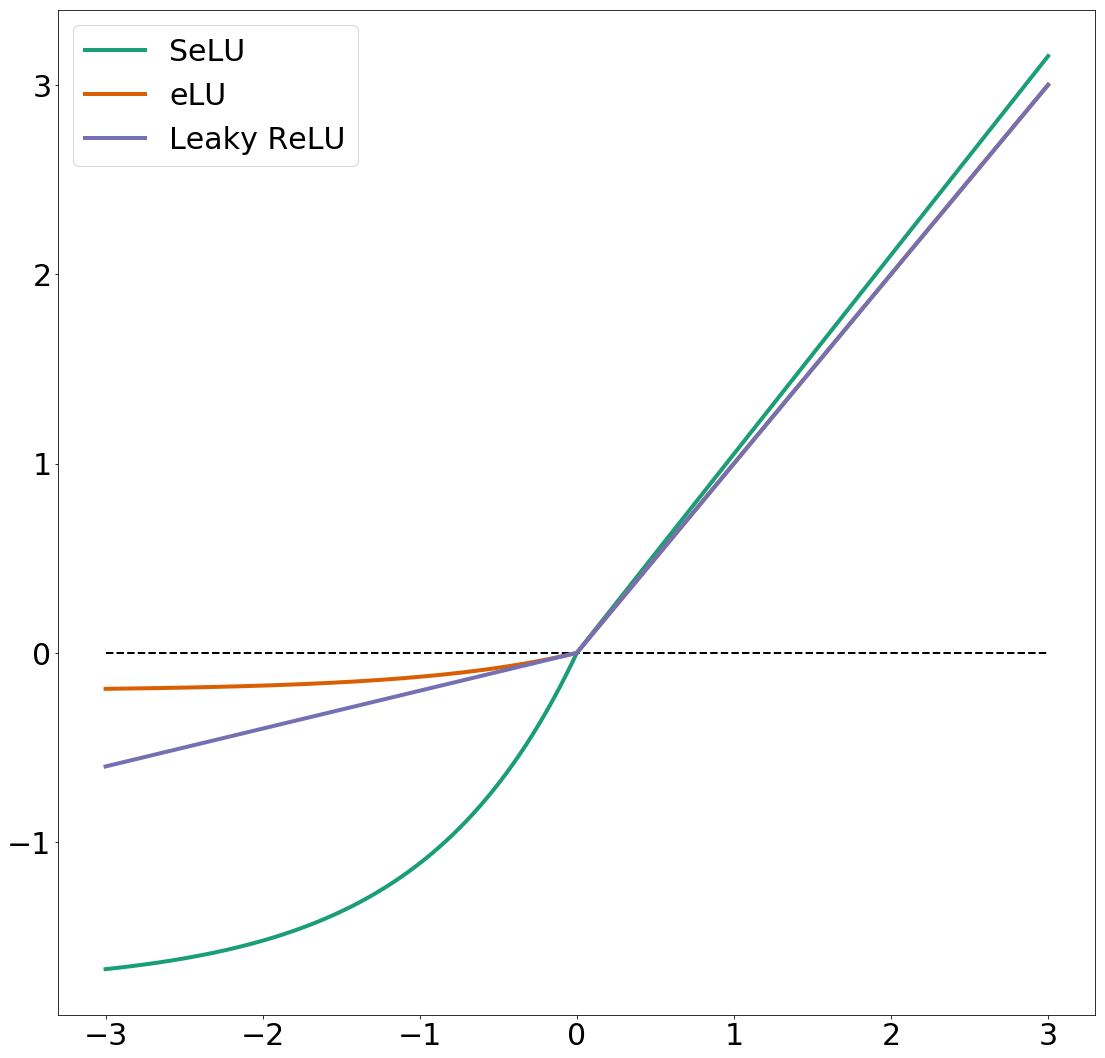

In [205]:
function_names_keras = [
    SELU_FUNCTION_NAME, ELU_FUNCTION_NAME, LEAKY_RELU_FUNCTION_NAME
]
function_names_fancy = ['SeLU', 'eLU', 'Leaky ReLU']
input_values = numpy.linspace(-3, 3, num=1000, dtype=float)

line_width = 4
colour_by_function = numpy.array([[27, 158, 119],
                                  [217, 95, 2],
                                  [117, 112, 179]], dtype=float) / 255

_, axes_objects_2d_list = _init_figure_panels(num_rows=1, num_columns=1)
axes_object = axes_objects_2d_list[0][0]

axes_object.plot(
    input_values, numpy.zeros(input_values.shape),
    linewidth=line_width / 2, linestyle='dashed', color=numpy.full(3, 0.))

for i in range(len(function_names_keras)):
    these_output_values = do_activation(
        input_values=input_values, function_name=function_names_keras[i])

    axes_object.plot(
        input_values, these_output_values,
        linewidth=line_width, linestyle='solid',
        color=colour_by_function[i, :], label=function_names_fancy[i])

axes_object.legend()

The next performs stand-alone 2-D pooling (not as part of CNN-training).

In [194]:
def do_2d_pooling(
        feature_matrix, stride_length_px=2, pooling_type_string='max'):
    """Runs 2-D feature maps through pooling filter.

    M = number of rows before pooling
    N = number of columns after pooling
    m = number of rows after pooling
    n = number of columns after pooling

    :param feature_matrix: Input feature maps (numpy array).  Dimensions must be
        M x N x C_i or 1 x M x N x C_i.
    :param stride_length_px: Stride length (pixels).  The pooling window will
        move by this many rows or columns at a time as it slides over each input
        feature map.
    :param pooling_type_string: Pooling type (must be accepted by
        `_check_pooling_type`).
    :return: feature_matrix: Output feature maps (numpy array).  Dimensions will
        be 1 x m x n x C.
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_integer(stride_length_px)
    error_checking.assert_is_geq(stride_length_px, 2)
    _check_pooling_type(pooling_type_string)

    if len(feature_matrix.shape) == 3:
        feature_matrix = numpy.expand_dims(feature_matrix, axis=0)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)

    feature_tensor = K.pool2d(
        x=K.variable(feature_matrix), pool_mode=pooling_type_string,
        pool_size=(stride_length_px, stride_length_px),
        strides=(stride_length_px, stride_length_px), padding='valid',
        data_format='channels_last')
    return feature_tensor.eval(session=K.get_session())

The next cell applies max-pooling, with stride length = 2, to an input iamge (grid of wet-bulb potential temperature).

Text(0.5,1,'After max-pooling')

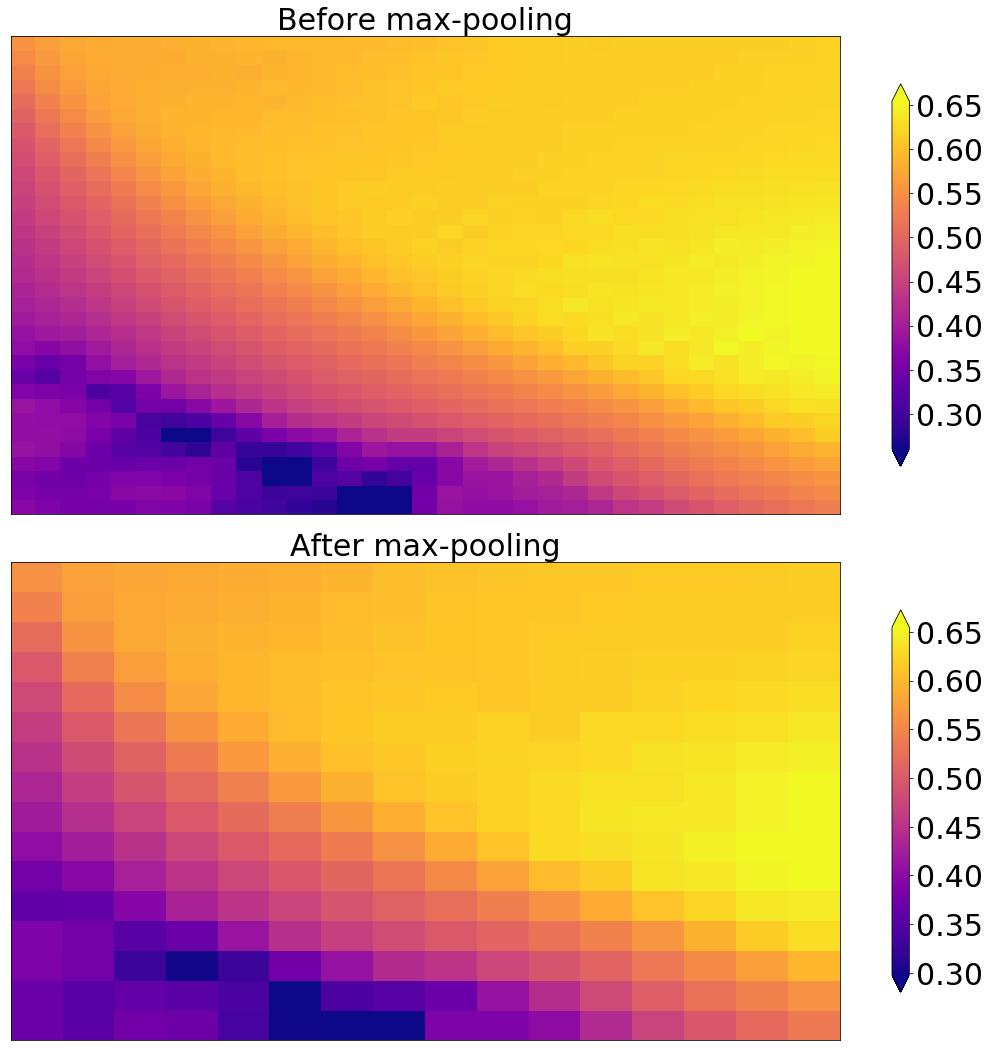

In [195]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before max-pooling')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After max-pooling')

The next cell does mean-pooling instead of max-pooling.

Text(0.5,1,'After mean-pooling')

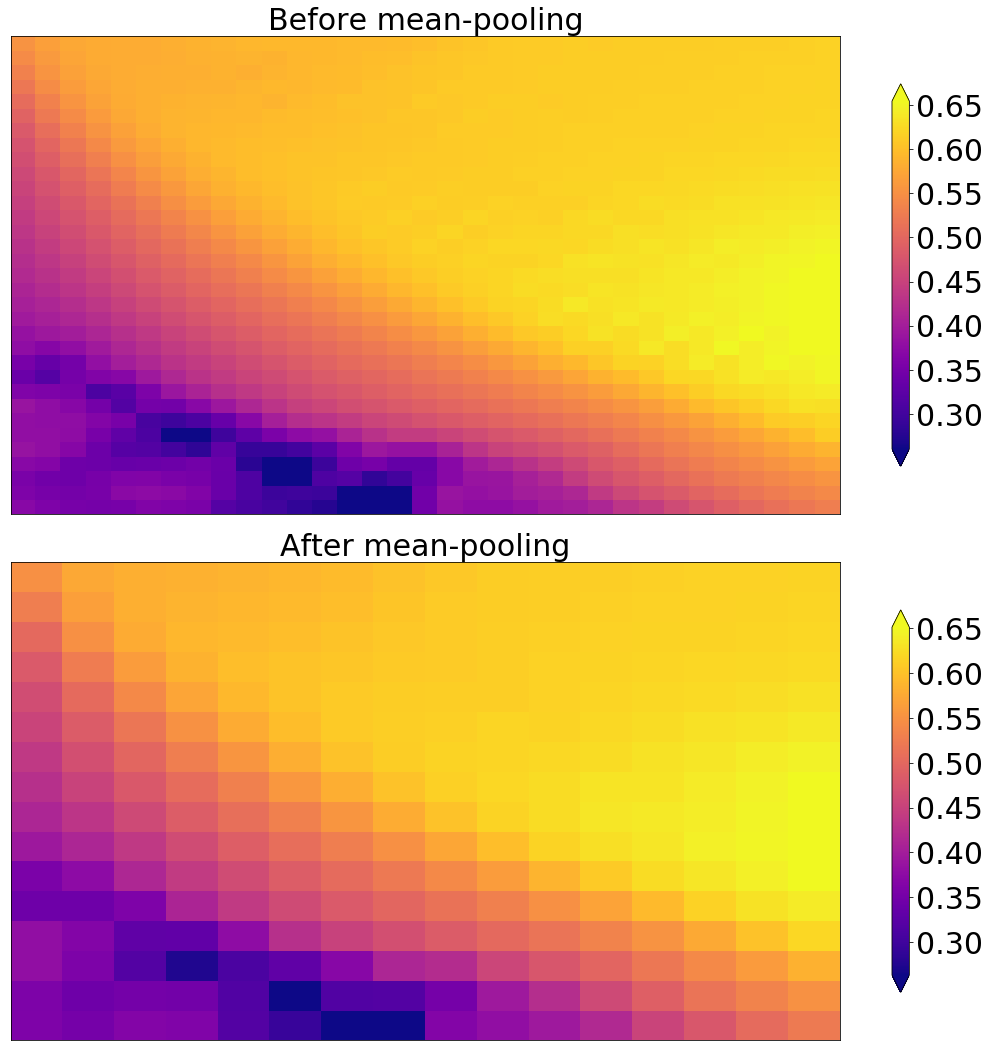

In [196]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before mean-pooling')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MEAN_POOLING_TYPE_STRING)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After mean-pooling')

The next cell does mean-pooling with a stride length of 4 instead of 2.

Text(0.5,1,'After max-pooling')

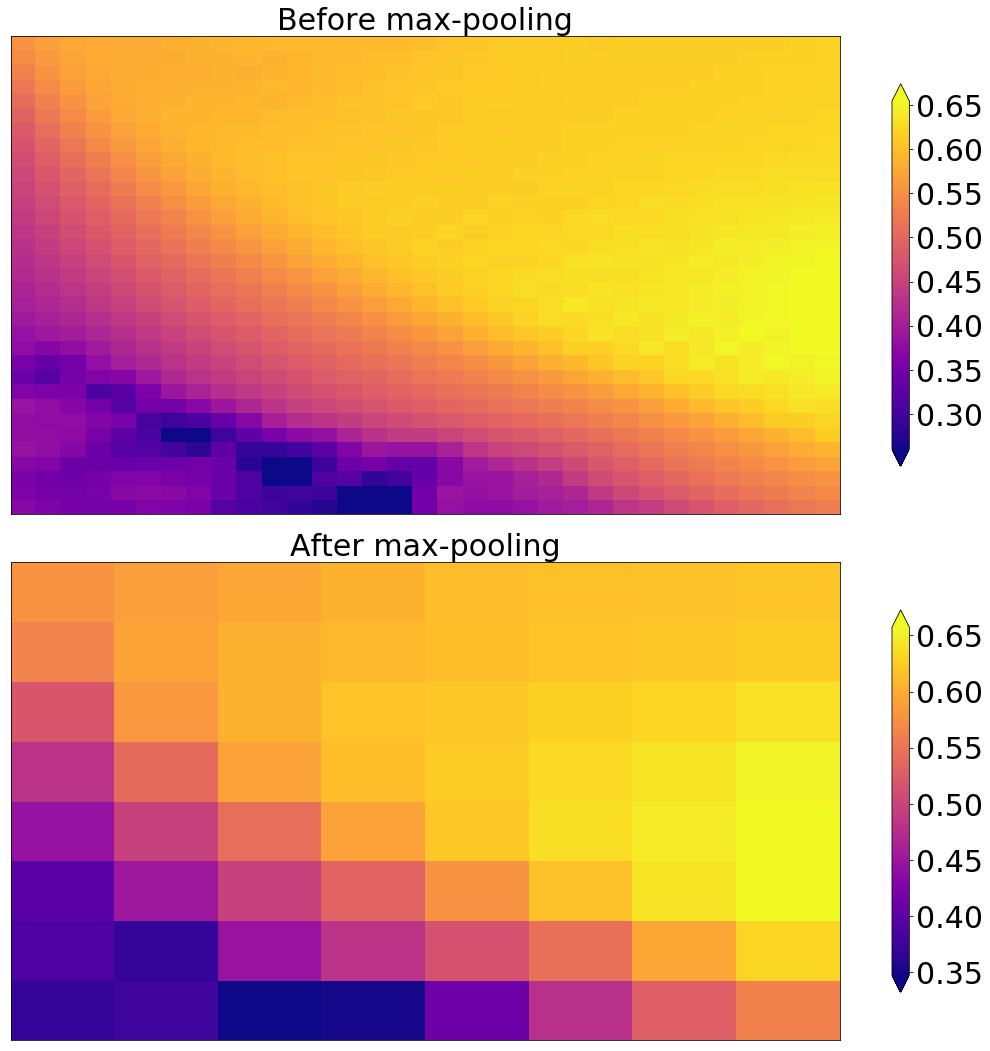

In [197]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before max-pooling')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=4,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After max-pooling')

The next cell does convolution, then activation, then pooling (similar to the workflow of a CNN).

Text(0.5,1,'After pooling')

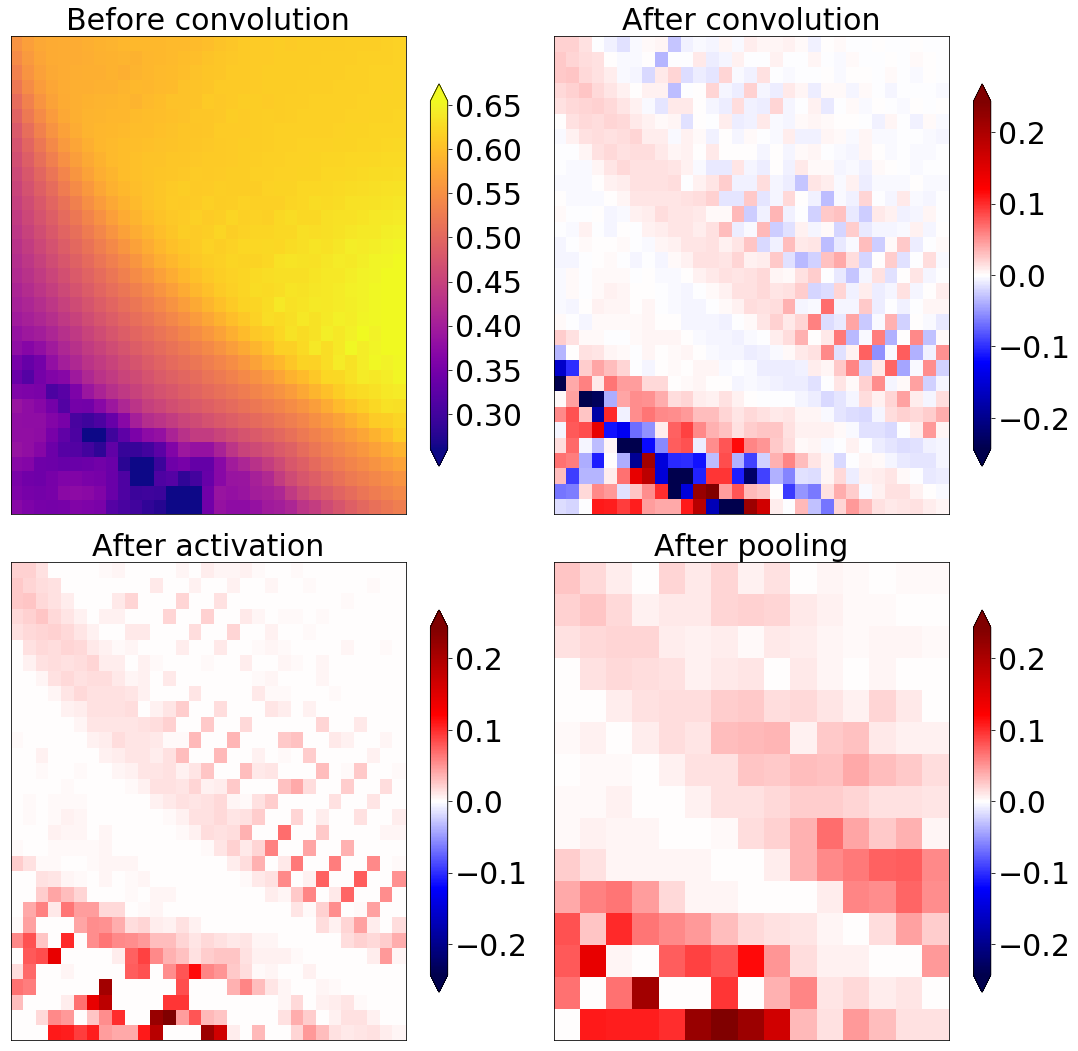

In [198]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[0, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=2)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix,
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = do_2d_convolution(
    feature_matrix=feature_matrix, kernel_matrix=kernel_matrix,
    pad_edges=False, stride_length_px=1)

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[0][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[0][1].set_title('After convolution')

feature_matrix = do_activation(
    input_values=feature_matrix, function_name='relu')

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][0],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][0].set_title('After activation')

feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][1].set_title('After pooling')

The following method does batch normalization.

In [199]:
def do_batch_normalization(
        feature_matrix, scale_parameter=1., shift_parameter=0.):
    """Performs batch normalization on each feature in the batch.

    --- REFERENCE ---

    Ioffe, S., and C. Szegedy, 2015: "Batch normalization: Accelerating deep
        network training by reducing internal covariate shift." International
        Conference on Machine Learning, Lille, France, International Machine
        Learning Society.

    :param feature_matrix: E-by-M-by-N-by-C numpy array of feature values.
    :param scale_parameter: Scale parameter (beta in the equation on page 3 of
        Ioffe and Szegedy 2015).
    :param shift_parameter: Shift parameter (gamma in the equation).
    :return: feature_matrix: Feature matrix after batch norm (same dimensions).
    """

    error_checking.assert_is_numpy_array_without_nan(feature_matrix)
    error_checking.assert_is_numpy_array(feature_matrix, num_dimensions=4)
    error_checking.assert_is_greater(scale_parameter, 0.)

    # The following matrices will be M x N x C.
    stdev_matrix = numpy.std(feature_matrix, axis=0, ddof=1)
    mean_matrix = numpy.mean(feature_matrix, axis=0)

    # The following matrices will be E x M x N x C.
    stdev_matrix = numpy.expand_dims(stdev_matrix, axis=0)
    stdev_matrix = numpy.repeat(stdev_matrix, feature_matrix.shape[0], axis=0)
    mean_matrix = numpy.expand_dims(mean_matrix, axis=0)
    mean_matrix = numpy.repeat(mean_matrix, feature_matrix.shape[0], axis=0)

    return shift_parameter + scale_parameter * (
        (feature_matrix - mean_matrix) / (stdev_matrix + K.epsilon())
    )

The next cell applies batch normalization with the default shift and scale parameters.

Text(0.5,1,'After batch normalization')

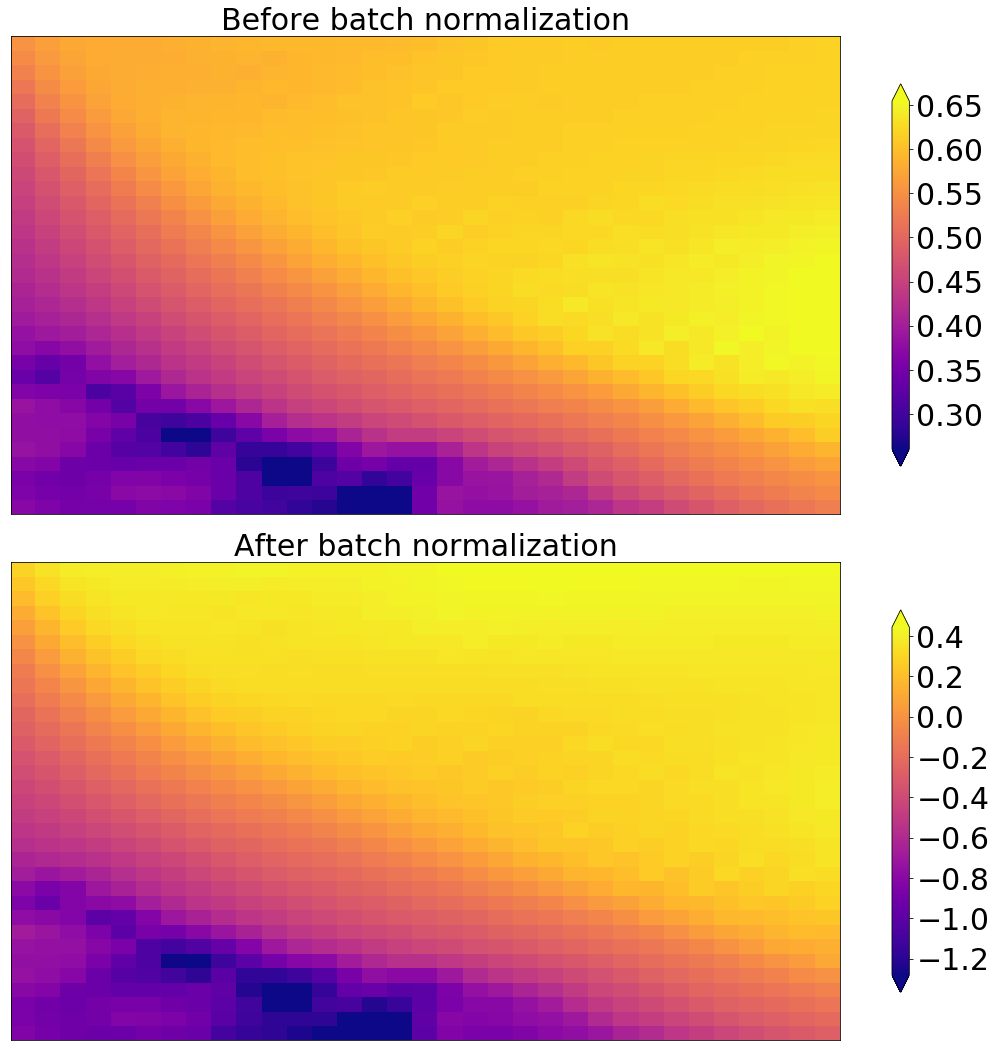

In [200]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix[0, ...],
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before batch normalization')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=1., shift_parameter=0.)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After batch normalization')

The next cell applies batch normalization with non-default parameters.

Text(0.5,1,'After batch normalization')

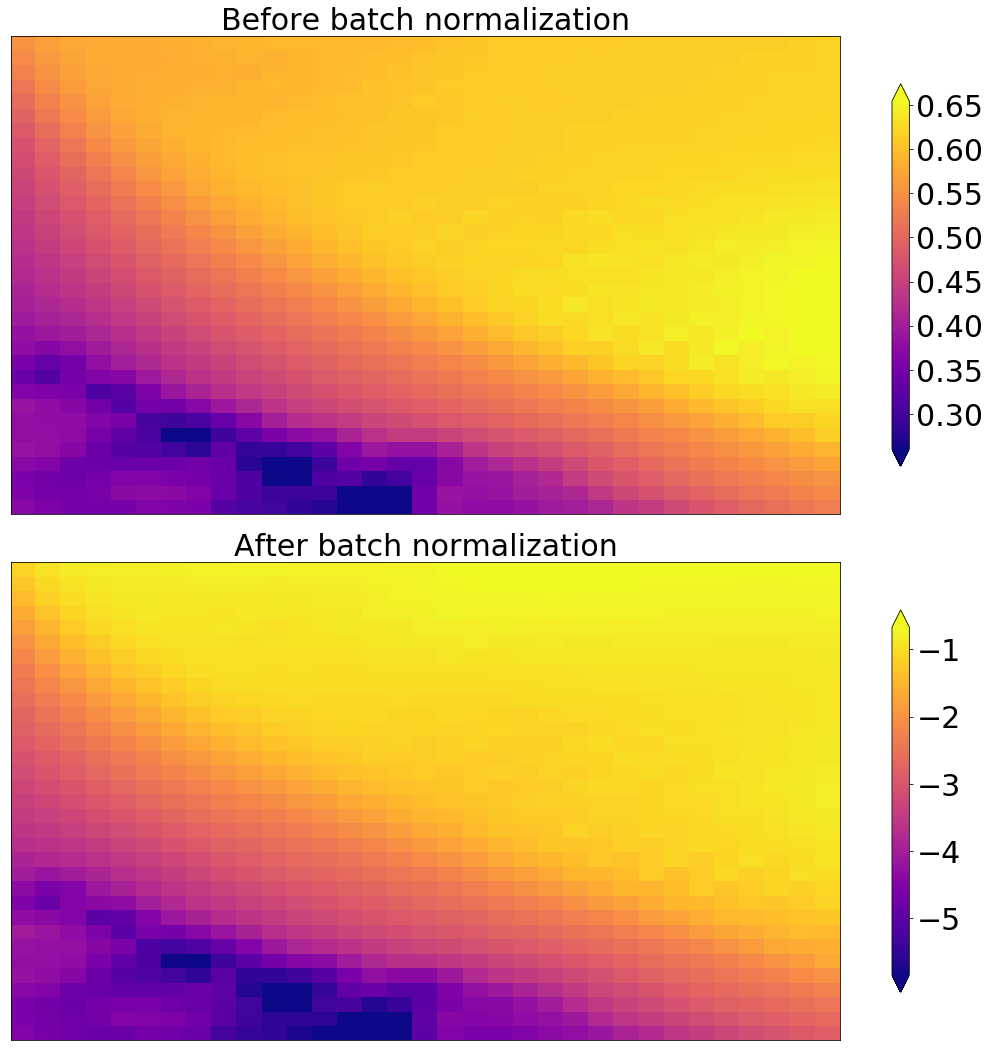

In [201]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=1)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix[0, ...],
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before batch normalization')

feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=3., shift_parameter=-2.)

plot_feature_map(feature_matrix=feature_matrix[0, ..., 0],
                 axes_object=axes_objects_2d_list[1][0])
axes_objects_2d_list[1][0].set_title('After batch normalization')

The next cell does convolution, then activation, then batch normalization, then pooling (just like the workflow of a CNN with batch normalization).

Convolving over example 1 of 50...
Convolving over example 11 of 50...
Convolving over example 21 of 50...
Convolving over example 31 of 50...
Convolving over example 41 of 50...


[]

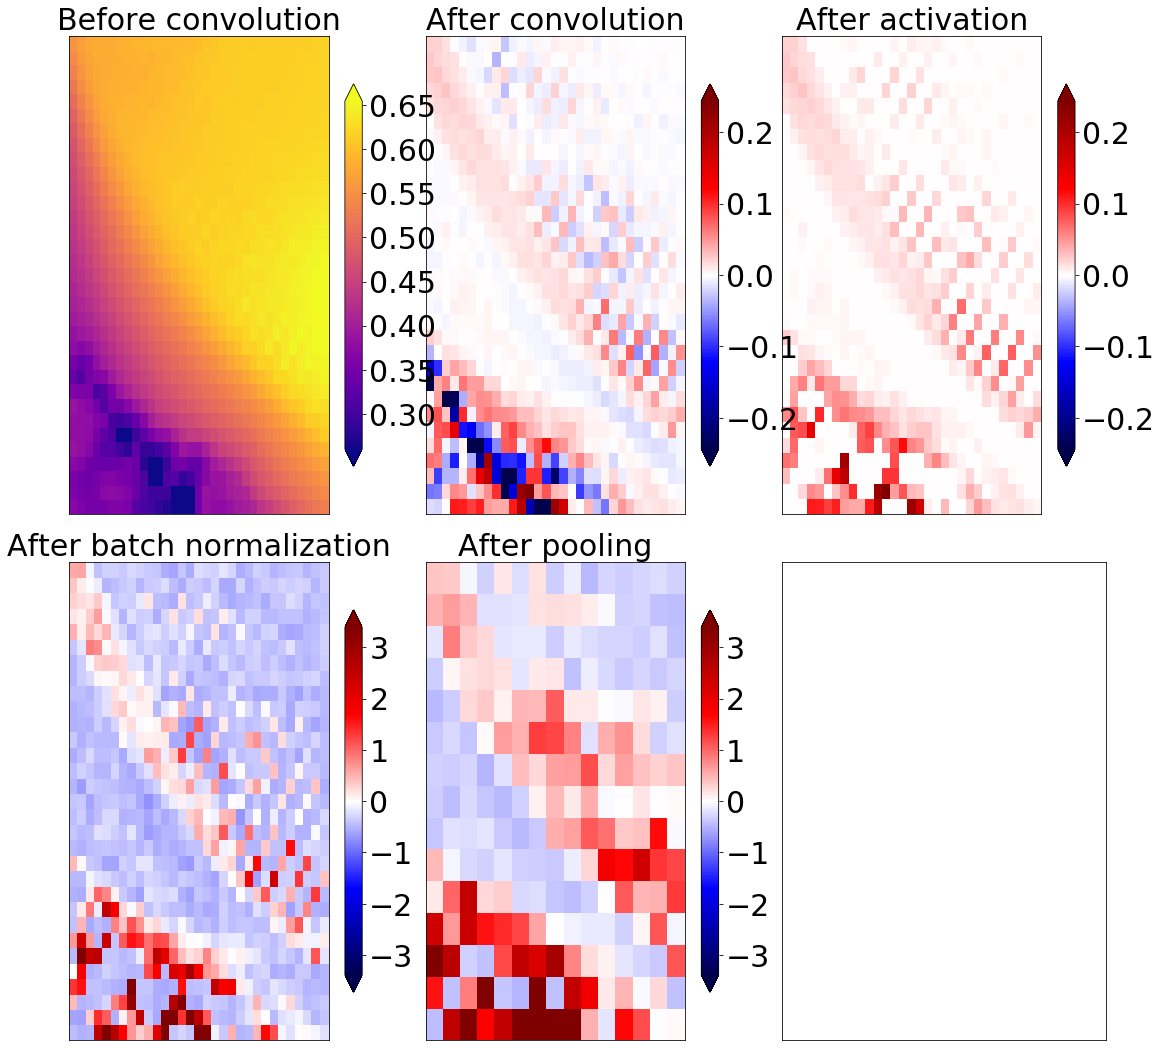

In [202]:
predictor_matrix = training_example_dict[PREDICTOR_MATRIX_KEY]
wet_bulb_theta_index = predictor_names.index(WET_BULB_THETA_NAME)
wet_bulb_theta_matrix = predictor_matrix[:50, ..., wet_bulb_theta_index]

_, axes_objects_2d_list = _init_figure_panels(num_rows=2, num_columns=3)
plot_feature_map(feature_matrix=wet_bulb_theta_matrix[0, ...],
                 axes_object=axes_objects_2d_list[0][0])
axes_objects_2d_list[0][0].set_title('Before convolution')

orig_feature_matrix = numpy.expand_dims(wet_bulb_theta_matrix, axis=-1)
kernel_matrix = numpy.expand_dims(EDGE_DETECTOR_MATRIX1, axis=-1)
kernel_matrix = numpy.expand_dims(kernel_matrix, axis=-1)

feature_matrix = None
num_examples = orig_feature_matrix.shape[0]

for i in range(num_examples):
    if numpy.mod(i, 10) == 0:
        print 'Convolving over example {0:d} of {1:d}...'.format(
            i + 1, num_examples)

    this_feature_matrix = do_2d_convolution(
        feature_matrix=orig_feature_matrix[[i], ...],
        kernel_matrix=kernel_matrix, pad_edges=False, stride_length_px=1)

    if feature_matrix is None:
        feature_matrix = this_feature_matrix + 0.
    else:
        feature_matrix = numpy.concatenate(
            (feature_matrix, this_feature_matrix), axis=0)

max_colour_value = numpy.percentile(
    numpy.absolute(feature_matrix[0, ...]), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[0][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[0][1].set_title('After convolution')

feature_matrix = do_activation(
    input_values=feature_matrix, function_name='relu')

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[0][2],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[0][2].set_title('After activation')

feature_matrix = do_batch_normalization(
    feature_matrix=feature_matrix, scale_parameter=1., shift_parameter=0.)
feature_matrix = feature_matrix[[0], ...]

max_colour_value = numpy.percentile(numpy.absolute(feature_matrix), 99.)
min_colour_value = -1 * max_colour_value
plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][0],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][0].set_title('After batch normalization')

feature_matrix = do_2d_pooling(
    feature_matrix=feature_matrix, stride_length_px=2,
    pooling_type_string=MAX_POOLING_TYPE_STRING)

plot_feature_map(
    feature_matrix=feature_matrix[0, ..., 0],
    axes_object=axes_objects_2d_list[1][1],
    colour_map_object=pyplot.cm.seismic,
    min_colour_value=min_colour_value, max_colour_value=max_colour_value)
axes_objects_2d_list[1][1].set_title('After pooling')

axes_objects_2d_list[1][2].set_xticks([])
axes_objects_2d_list[1][2].set_yticks([])

The following methods will help you create a full CNN.

In [206]:
def _get_activation_layer(function_name, alpha_parameter=0.2):
    """Creates activation layer.

    :param function_name: See doc for `do_activation`.
    :param alpha_parameter: Same.
    :return: layer_object: Instance of `keras.layers.Activation`,
        `keras.layers.ELU`, or `keras.layers.LeakyReLU`.
    """

    if function_name == ELU_FUNCTION_NAME:
        return keras.layers.ELU(alpha=alpha_parameter)

    if function_name == LEAKY_RELU_FUNCTION_NAME:
        return keras.layers.LeakyReLU(alpha=alpha_parameter)

    return keras.layers.Activation(function_name)


def _get_batch_norm_layer():
    """Creates batch-normalization layer.

    :return: layer_object: Instance of `keras.layers.BatchNormalization`.
    """

    return keras.layers.BatchNormalization(
        axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)


def _get_2d_pooling_layer(stride_length_px, pooling_type_string):
    """Creates 2-D pooling layer.
    
    :param stride_length_px: See doc for `do_pooling`.
    :param pooling_type_string: Same.
    :return: layer_object: Instance of `keras.layers.MaxPooling2D` or
        `keras.layers.AveragePooling2D`.
    """

    if pooling_type_string == MAX_POOLING_TYPE_STRING:
        return keras.layers.MaxPooling2D(
            pool_size=(stride_length_px, stride_length_px),
            strides=(stride_length_px, stride_length_px),
            padding='valid', data_format='channels_last')

    return keras.layers.AveragePooling2D(
        pool_size=(stride_length_px, stride_length_px),
        strides=(stride_length_px, stride_length_px),
        padding='valid', data_format='channels_last')


def _get_dense_layer_dimensions(
        num_features, num_predictions, num_dense_layers):
    """Returns dimensions (num input and output features) for each dense layer.

    D = number of dense layers

    :param num_features: Number of features (inputs to the first dense layer).
    :param num_predictions: Number of predictions (outputs from the last dense
        layer).
    :param num_dense_layers: Number of dense layers.
    :return: num_inputs_by_layer: length-D numpy array with number of input
        features per dense layer.
    :return: num_outputs_by_layer: length-D numpy array with number of output
        features per dense layer.
    """

    e_folding_param = (
        float(-1 * num_dense_layers) /
        numpy.log(float(num_predictions) / num_features)
    )

    dense_layer_indices = numpy.linspace(
        0, num_dense_layers - 1, num=num_dense_layers, dtype=float)
    num_inputs_by_layer = num_features * numpy.exp(
        -1 * dense_layer_indices / e_folding_param)
    num_inputs_by_layer = numpy.round(num_inputs_by_layer).astype(int)

    num_outputs_by_layer = numpy.concatenate((
        num_inputs_by_layer[1:],
        numpy.array([num_predictions], dtype=int)
    ))

    return num_inputs_by_layer, num_outputs_by_layer

The next cell creates a simple CNN architecture.

In [208]:
num_grid_rows = training_example_dict[PREDICTOR_MATRIX_KEY].shape[1]
num_grid_columns = training_example_dict[PREDICTOR_MATRIX_KEY].shape[2]
num_channels = training_example_dict[PREDICTOR_MATRIX_KEY].shape[3]

input_layer_object = keras.layers.Input(
    shape=(num_grid_rows, num_grid_columns, num_channels)
)
last_layer_object = input_layer_object

conv_layer_object = keras.layers.Conv2D(
    filters=24, kernel_size=(3, 3), strides=(1, 1),
    padding='valid', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='relu')
last_layer_object = activation_layer_object(last_layer_object)

conv_layer_object = keras.layers.Conv2D(
    filters=48, kernel_size=(3, 3), strides=(1, 1),
    padding='valid', data_format='channels_last', dilation_rate=(1, 1),
    activation=None, use_bias=True)
last_layer_object = conv_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='relu')
last_layer_object = activation_layer_object(last_layer_object)

pooling_layer_object = _get_2d_pooling_layer(
    stride_length_px=2, pooling_type_string=MAX_POOLING_TYPE_STRING)
last_layer_object = pooling_layer_object(last_layer_object)

flattening_layer_object = keras.layers.Flatten()
last_layer_object = flattening_layer_object(last_layer_object)

dense_layer_object = keras.layers.Dense(
    128, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros')
last_layer_object = dense_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='relu')
last_layer_object = activation_layer_object(last_layer_object)

dropout_layer_object = keras.layers.Dropout(rate=0.5)
last_layer_object = dropout_layer_object(last_layer_object)

dense_layer_object = keras.layers.Dense(
    3, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros')
last_layer_object = dense_layer_object(last_layer_object)

activation_layer_object = _get_activation_layer(function_name='softmax')
last_layer_object = activation_layer_object(last_layer_object)

model_object = keras.models.Model(
    inputs=input_layer_object, outputs=last_layer_object)
model_object.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=LIST_OF_METRIC_FUNCTIONS)

model_object.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 33, 33, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 31, 31, 24)        672       
_________________________________________________________________
activation_33 (Activation)   (None, 31, 31, 24)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 48)        10416     
_________________________________________________________________
activation_34 (Activation)   (None, 29, 29, 48)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 48)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9408)              0         
__________

The following method is a generator, which allows Keras models to be trained "on the fly".  This means that, instead of reading all the input data into memory at once, input data are read as they are needed, when requested by the Keras backend.

In [209]:
def input_generator(
        top_training_dir_name, predictor_names, num_examples_per_batch,
        num_half_rows, num_half_columns):
    """Generates input examples for training Keras model on the fly.

    :param top_training_dir_name: Name of top-level directory with training
        examples (see doc for `find_training_file`).
    :param predictor_names: See doc for `read_input_examples`.
    :param num_examples_per_batch: Number of examples to generate per batch.
    :param num_half_rows: See doc for `read_input_examples`.
    :param num_half_columns: Same.
    :return: predictor_matrix: E-by-M-by-N-by-C numpy array of predictor
        variables.
    :return: target_matrix: E-by-K numpy array of target values.  If
        target_matrix[i, k] = 1, the [i]th example belongs to the [k]th class.
        Class-to-integer encodings are defined with the "ENUM" constants at the
        top of this notebook.
    """

    error_checking.assert_is_integer(num_examples_per_batch)
    error_checking.assert_is_geq(num_examples_per_batch, 100)

    training_file_names = find_many_training_files(
        top_training_dir_name=top_training_dir_name,
        first_batch_number=0, last_batch_number=int(1e10))
    random.shuffle(training_file_names)

    num_files = len(training_file_names)
    file_index = 0
    batch_indices = numpy.linspace(
        0, num_examples_per_batch - 1, num=num_examples_per_batch, dtype=int)

    num_examples_in_memory = 0
    full_predictor_matrix = None
    full_target_matrix = None

    while True:
        while num_examples_in_memory < num_examples_per_batch:
            print 'Reading data from: "{0:s}"...'.format(
                training_file_names[file_index])

            this_example_dict = read_input_examples(
                netcdf_file_name=training_file_names[file_index],
                predictor_names_to_keep=predictor_names,
                num_half_rows_to_keep=num_half_rows,
                num_half_columns_to_keep=num_half_columns)

            file_index += 1
            if file_index >= num_files:
                file_index = 0

            this_num_examples = len(this_example_dict[TARGET_TIMES_KEY])
            if this_num_examples == 0:
                continue

            if full_target_matrix is None or full_target_matrix.size == 0:
                full_predictor_matrix = (
                    this_example_dict[PREDICTOR_MATRIX_KEY] + 0.
                )
                full_target_matrix = this_example_dict[TARGET_MATRIX_KEY] + 0
            else:
                full_predictor_matrix = numpy.concatenate(
                    (full_predictor_matrix,
                     this_example_dict[PREDICTOR_MATRIX_KEY]),
                    axis=0)
                full_target_matrix = numpy.concatenate(
                    (full_target_matrix, this_example_dict[TARGET_MATRIX_KEY]),
                    axis=0)

            num_examples_in_memory = full_target_matrix.shape[0]

        predictor_matrix = full_predictor_matrix[batch_indices, ...].astype(
            'float32')
        target_matrix = full_target_matrix[batch_indices, ...].astype('float64')

        class_fractions = numpy.sum(target_matrix, axis=0)
        print 'Number of examples in each class: {0:s}'.format(
            str(class_fractions))

        num_examples_in_memory = 0
        full_predictor_matrix = None
        full_target_matrix = None

        yield (predictor_matrix, target_matrix)

The following method trains a CNN.

In [210]:
def train_model(
        model_object, output_model_file_name, num_epochs,
        num_examples_per_batch, num_training_batches_per_epoch,
        top_training_dir_name, num_validation_batches_per_epoch,
        top_validation_dir_name, predictor_names, num_half_rows,
        num_half_columns):
    """Trains Keras model.

    This method returns nothing.  The main effect is that after each epoch the
    updated model is saved to `output_model_file_name`.

    :param model_object: Model with pre-defined architecture (instance of
        `keras.models`).
    :param output_model_file_name: Path to output file.  The model will be saved
        here, after each epoch, in HDF5 format.
    :param num_epochs: Number of epochs.
    :param num_examples_per_batch: Number of examples per batch.
    :param num_training_batches_per_epoch: Number of training batches per epoch.
    :param top_training_dir_name: Name of top-level directory with training data
        (see `find_training_file`).
    :param num_validation_batches_per_epoch: Number of validation (monitoring)
        batches per epoch.
    :param top_validation_dir_name: Name of top-level directory with
        "validation" (monitoring) data.  See `find_training_file`.
    :param predictor_names: See doc for `read_input_examples`.
    :param num_half_rows: Same.
    :param num_half_columns: Same.
    """

    error_checking.assert_is_string(output_model_file_name)
    error_checking.assert_is_integer(num_epochs)
    error_checking.assert_is_geq(num_epochs, 1)
    error_checking.assert_is_integer(num_training_batches_per_epoch)
    error_checking.assert_is_geq(num_training_batches_per_epoch, 1)
    error_checking.assert_is_integer(num_validation_batches_per_epoch)
    error_checking.assert_is_geq(num_validation_batches_per_epoch, 1)

    checkpoint_object = keras.callbacks.ModelCheckpoint(
        output_model_file_name, monitor='val_loss', verbose=1,
        save_best_only=True, save_weights_only=False, mode='min', period=1)

    model_object.fit_generator(
        generator=input_generator(
            top_training_dir_name=top_training_dir_name,
            predictor_names=predictor_names,
            num_examples_per_batch=num_examples_per_batch,
            num_half_rows=num_half_rows,
            num_half_columns=num_half_columns),
        steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
        verbose=1, class_weight=None, callbacks=[checkpoint_object],
        validation_data=input_generator(
            top_training_dir_name=top_validation_dir_name,
            predictor_names=predictor_names,
            num_examples_per_batch=num_examples_per_batch,
            num_half_rows=num_half_rows,
            num_half_columns=num_half_columns),
        validation_steps=num_validation_batches_per_epoch)

The next cell calls the above method to train the simple CNN, whose architecture we defined a few cells above.

In [214]:
output_model_file_name = '{0:s}/simple_cnn.h5'.format(OUTPUT_DIR_NAME)

num_grid_rows = training_example_dict[PREDICTOR_MATRIX_KEY].shape[1]
num_half_rows = (num_grid_rows - 1) / 2
num_grid_columns = training_example_dict[PREDICTOR_MATRIX_KEY].shape[2]
num_half_columns = (num_grid_columns - 1) / 2

train_model(
    model_object=model_object,
    output_model_file_name=output_model_file_name, num_epochs=5,
    num_examples_per_batch=512, num_training_batches_per_epoch=32,
    top_training_dir_name=TOP_TRAINING_DIR_NAME,
    num_validation_batches_per_epoch=16,
    top_validation_dir_name=TOP_VALIDATION_DIR_NAME,
    predictor_names=training_example_dict[PREDICTOR_NAMES_KEY],
    num_half_rows=num_half_rows, num_half_columns=num_half_columns)

Epoch 1/5
Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140325.nc"...


KeyError: 'target_times_unix_sec'

The next cell creates a fancier CNN architecture, including batch normalization, L1 and L2 regularization, and a long list of input arguments that you can play with.

In [215]:
l1_weight = 0.
l2_weight = 0.001
first_num_filters = 16
num_kernel_rows = 3
num_kernel_columns = 3
activation_function_name = LEAKY_RELU_FUNCTION_NAME + ''
use_batch_normalization = False
pooling_type_string = MAX_POOLING_TYPE_STRING + ''
num_conv_layers = 2
num_dense_layers = 3
dense_layer_dropout_fraction = 0.5

regularizer_object = keras.regularizers.l1_l2(l1=l1_weight, l2=l2_weight)
input_layer_object = keras.layers.Input(
    shape=training_example_dict[PREDICTOR_MATRIX_KEY].shape[1:]
)

last_layer_object = input_layer_object
next_num_filters = None

for _ in range(num_conv_layers):
    if next_num_filters is None:
        next_num_filters = first_num_filters + 0
    else:
        next_num_filters = 2 * next_num_filters

    conv_layer_object = keras.layers.Conv2D(
        filters=next_num_filters,
        kernel_size=(num_kernel_rows, num_kernel_columns),
        strides=(1, 1),
        padding='valid', data_format='channels_last', dilation_rate=(1, 1),
        activation=None, use_bias=True,
        kernel_regularizer=regularizer_object)
    last_layer_object = conv_layer_object(last_layer_object)

    activation_layer_object = _get_activation_layer(
        function_name=activation_function_name)
    last_layer_object = activation_layer_object(last_layer_object)

    if use_batch_normalization:
        batch_norm_layer_object = _get_batch_norm_layer()
        last_layer_object = batch_norm_layer_object(last_layer_object)

    pooling_layer_object = _get_2d_pooling_layer(
        stride_length_px=2, pooling_type_string=pooling_type_string)
    last_layer_object = pooling_layer_object(last_layer_object)

these_dimensions = numpy.array(
    last_layer_object.get_shape().as_list()[1:], dtype=int)
num_scalar_features = numpy.prod(these_dimensions)

flattening_layer_object = keras.layers.Flatten()
last_layer_object = flattening_layer_object(last_layer_object)

_, num_outputs_by_dense_layer = _get_dense_layer_dimensions(
    num_features=num_scalar_features, num_predictions=3,
    num_dense_layers=num_dense_layers)

for i in range(num_dense_layers):
    dense_layer_object = keras.layers.Dense(
        num_outputs_by_dense_layer[i], activation=None, use_bias=True,
        kernel_initializer='glorot_uniform', bias_initializer='zeros',
        kernel_regularizer=regularizer_object)
    last_layer_object = dense_layer_object(last_layer_object)

    if i == num_dense_layers - 1:
        activation_layer_object = _get_activation_layer(
            function_name='softmax')
        last_layer_object = activation_layer_object(last_layer_object)
        break

    activation_layer_object = _get_activation_layer(
        function_name=activation_function_name)
    last_layer_object = activation_layer_object(last_layer_object)

    if use_batch_normalization:
        batch_norm_layer_object = _get_batch_norm_layer()
        last_layer_object = batch_norm_layer_object(last_layer_object)

    if dense_layer_dropout_fraction > 0:
        dropout_layer_object = keras.layers.Dropout(
            rate=dense_layer_dropout_fraction)
        last_layer_object = dropout_layer_object(last_layer_object)

model_object = keras.models.Model(
    inputs=input_layer_object, outputs=last_layer_object)
model_object.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=LIST_OF_METRIC_FUNCTIONS)

model_object.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 33, 33, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 31, 31, 16)        448       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 31, 31, 16)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 32)        4640      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 32)          0         
__________

The next cell trains the fancy CNN.

In [228]:
output_model_file_name = '{0:s}/fancy_cnn.h5'.format(OUTPUT_DIR_NAME)

num_grid_rows = training_example_dict[PREDICTOR_MATRIX_KEY].shape[1]
num_half_rows = (num_grid_rows - 1) / 2
num_grid_columns = training_example_dict[PREDICTOR_MATRIX_KEY].shape[2]
num_half_columns = (num_grid_columns - 1) / 2

train_model(
    model_object=model_object,
    output_model_file_name=output_model_file_name, num_epochs=5,
    num_examples_per_batch=16, num_training_batches_per_epoch=32,
    top_training_dir_name=TOP_TRAINING_DIR_NAME,
    num_validation_batches_per_epoch=16,
    top_validation_dir_name=TOP_VALIDATION_DIR_NAME,
    predictor_names=training_example_dict[PREDICTOR_NAMES_KEY],
    num_half_rows=num_half_rows, num_half_columns=num_half_columns)

Epoch 1/5
Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140129.nc"...
Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140092.nc"...
Number of examples in each class: [277. 112. 123.]
Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140114.nc"...
Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140220.nc"...
Number of examples in each class: [262. 118. 132.]
Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/shuffled/training/batches0140000-0140999/downsized_3d_examples_batch0140088.nc"...
Number of exa


KeyboardInterrupt



The following methods are used to find testing files.  Testing data come from a different year (2017) than training and validation data (2008-16), so the testing data are temporally independent of the training and validation data.  Also, the testing data are not downsampled: the class fractions are 98.95% no front, 0.27% warm front, and 0.78% cold front.  Due to these properties (independence and class distribution similar to the true population distribution), testing data can be used to assess the performance of a trained CNN "in the wild".

In [20]:
def _file_name_to_times(testing_file_name):
    """Parses start/end times from name of testing file.

    :param testing_file_name: See doc for `find_testing_file`.
    :return: first_time_unix_sec: First time in file.
    :return: last_time_unix_sec: Last time in file.
    :raises: ValueError: if times cannot be found in file name.
    """

    pathless_file_name = os.path.split(testing_file_name)[-1]
    extensionless_file_name = os.path.splitext(pathless_file_name)[0]
    time_strings = extensionless_file_name.split(
        'downsized_3d_examples_')[-1].split('-')

    first_time_unix_sec = time_conversion.string_to_unix_sec(
        time_strings[0], TIME_FORMAT)
    last_time_unix_sec = time_conversion.string_to_unix_sec(
        time_strings[-1], TIME_FORMAT)

    return first_time_unix_sec, last_time_unix_sec


def find_testing_file(
        top_testing_dir_name, first_time_unix_sec, last_time_unix_sec,
        raise_error_if_missing=True):
    """Locates file with testing examples.

    :param top_testing_dir_name: Name of top-level directory with testing
        examples.
    :param first_time_unix_sec: First time in desired file.
    :param last_time_unix_sec: Last time in desired file.
    :param raise_error_if_missing: Boolean flag.  If file is missing and
        `raise_error_if_missing = True`, this method will error out.
    :return: testing_file_name: Path to file with testing examples.  If file
        is missing and `raise_error_if_missing = False`, this method will just
        return the expected path.
    :raises: ValueError: if file is missing and `raise_error_if_missing = True`.
    """

    error_checking.assert_is_string(top_testing_dir_name)
    error_checking.assert_is_integer(first_time_unix_sec)
    error_checking.assert_is_integer(last_time_unix_sec)
    error_checking.assert_is_geq(last_time_unix_sec, first_time_unix_sec)
    error_checking.assert_is_boolean(raise_error_if_missing)

    testing_file_name = (
        '{0:s}/downsized_3d_examples_{1:s}-{2:s}.nc'
    ).format(
        top_testing_dir_name,
        time_conversion.unix_sec_to_string(first_time_unix_sec, TIME_FORMAT),
        time_conversion.unix_sec_to_string(last_time_unix_sec, TIME_FORMAT)
    )

    if raise_error_if_missing and not os.path.isfile(testing_file_name):
        error_string = 'Cannot find file.  Expected at: "{0:s}"'.format(
            testing_file_name)
        raise ValueError(error_string)

    return testing_file_name


def find_many_testing_files(
        top_testing_dir_name, first_time_unix_sec, last_time_unix_sec):
    """Finds many files with testing examples.

    :param top_testing_dir_name: See doc for `find_testing_file`.
    :param first_time_unix_sec: First desired time.
    :param last_time_unix_sec: Last desired time.
    :return: testing_file_names: 1-D list of paths to testing files.
    :raises: ValueError: if no files are found.
    """

    error_checking.assert_is_string(top_testing_dir_name)
    error_checking.assert_is_integer(first_time_unix_sec)
    error_checking.assert_is_integer(last_time_unix_sec)
    error_checking.assert_is_geq(last_time_unix_sec, first_time_unix_sec)

    testing_file_pattern = (
        '{0:s}/downsized_3d_examples_{1:s}-{1:s}.nc'
    ).format(top_testing_dir_name, TIME_FORMAT_REGEX, TIME_FORMAT_REGEX)

    testing_file_names = glob.glob(testing_file_pattern)
    if len(testing_file_names) == 0:
        error_string = 'Cannot find any files with the pattern: "{0:s}"'.format(
            testing_file_names)
        raise ValueError(error_string)

    testing_file_names.sort()

    file_start_times_unix_sec = numpy.array(
        [_file_name_to_times(f)[0] for f in testing_file_names],
        dtype=int)
    file_end_times_unix_sec = numpy.array(
        [_file_name_to_times(f)[1] for f in testing_file_names],
        dtype=int)

    good_indices = numpy.where(numpy.invert(numpy.logical_or(
        file_start_times_unix_sec > last_time_unix_sec,
        file_end_times_unix_sec < first_time_unix_sec
    )))[0]

    if len(good_indices) == 0:
        error_string = (
            'Cannot find any files with time from {0:s} to {1:s}.'
        ).format(
            time_conversion.unix_sec_to_string(
                first_time_unix_sec, TIME_FORMAT),
            time_conversion.unix_sec_to_string(
                last_time_unix_sec, TIME_FORMAT)
        )
        raise ValueError(error_string)

    return [testing_file_names[i] for i in good_indices]

The following method uses a trained CNN to make predictions for testing data.

In [21]:
def make_predictions(model_object, testing_file_names, predictor_names_to_keep):
    """Uses a trained CNN to make predictions.

    :param model_object: Trained CNN (instance of `keras.models`).
    :param testing_file_names: 1-D list of paths to testing files (will be read
        by `read_input_examples`).
    :param predictor_names_to_keep: See doc for `read_input_examples`.
    :return: class_probability_matrix: E-by-3 numpy array of predicted
        probabilities.  class_probability_matrix[i, k] is the predicted
        probability that the [i]th example belongs to the [k]th class.
    :return: target_values: length-E numpy array of target values (integers).
        Possible values are `NO_FRONT_ENUM`, `WARM_FRONT_ENUM`, and
        `WARM_FRONT_ENUM`, listed at the top of this notebook.
    :return: permuted_probability_matrix: E-by-3-by-C numpy array, where
        permuted_probability_matrix[..., m] is the version of
        `class_probability_matrix` obtained when values of the [m]th predictor
        are permuted (spatially randomized for each example).
    """

    input_dimensions = numpy.array(
        model_object.layers[0].input.get_shape().as_list()[1:], dtype=int)

    num_grid_rows = input_dimensions[0]
    num_half_rows = (num_grid_rows - 1) / 2
    num_grid_columns = input_dimensions[1]
    num_half_columns = (num_grid_columns - 1) / 2
    num_predictors = len(predictor_names_to_keep)

    class_probability_matrix = None
    target_values = None
    permuted_probability_matrix = None

    for this_file_name in testing_file_names:
        print 'Reading data from: "{0:s}"...'.format(this_file_name)
        this_example_dict = read_input_examples(
            netcdf_file_name=this_file_name,
            predictor_names_to_keep=predictor_names_to_keep,
            num_half_rows_to_keep=num_half_rows,
            num_half_columns_to_keep=num_half_columns)

        print 'Making predictions with CNN...\n'
        these_target_values = numpy.argmax(
            this_example_dict[TARGET_MATRIX_KEY], axis=1)
        this_num_examples = len(these_target_values)

        this_probability_matrix = model_object.predict(
            this_example_dict[PREDICTOR_MATRIX_KEY],
            batch_size=this_num_examples)

        this_permuted_probability_matrix = None

        for m in range(num_predictors):
            this_permuted_predictor_matrix = (
                this_example_dict[PREDICTOR_MATRIX_KEY] + 0.
            )

            for i in range(this_num_examples):
                this_permuted_predictor_matrix[i, ..., m] = (
                    numpy.random.permutation(
                        this_permuted_predictor_matrix[i, ..., m]
                    )
                )

            this_new_probability_matrix = model_object.predict(
                this_permuted_predictor_matrix, batch_size=this_num_examples)
            this_new_probability_matrix = numpy.expand_dims(
                this_new_probability_matrix, axis=-1)

            if this_permuted_probability_matrix is None:
                this_permuted_probability_matrix = (
                    this_new_probability_matrix + 0.
                )
            else:
                this_permuted_probability_matrix = numpy.concatenate(
                    (this_permuted_probability_matrix,
                     this_new_probability_matrix),
                    axis=-1)

        if class_probability_matrix is None:
            class_probability_matrix = this_probability_matrix + 0.
            target_values = these_target_values + 0.
            permuted_probability_matrix = this_permuted_probability_matrix + 0.
        else:
            class_probability_matrix = numpy.concatenate(
                (class_probability_matrix, this_probability_matrix), axis=0)
            target_values = numpy.concatenate((
                target_values, these_target_values))
            permuted_probability_matrix = numpy.concatenate(
                (permuted_probability_matrix, this_permuted_probability_matrix),
                axis=0)

    return (class_probability_matrix, target_values.astype(int),
            permuted_probability_matrix)

The next cell uses a pre-trained CNN to make predictions for Feb 2017.

In [23]:
best_model_object = traditional_cnn.read_keras_model(BEST_MODEL_FILE_NAME)

first_testing_time_string = '2017020100'
last_testing_time_string = '2017022821'
testing_file_names = find_many_testing_files(
    top_testing_dir_name=TOP_TESTING_DIR_NAME,
    first_time_unix_sec=time_conversion.string_to_unix_sec(
        first_testing_time_string, '%Y%m%d%H'),
    last_time_unix_sec=time_conversion.string_to_unix_sec(
        last_testing_time_string, '%Y%m%d%H')
)

predictor_names_to_keep = [
    U_WIND_GRID_RELATIVE_NAME, V_WIND_GRID_RELATIVE_NAME, TEMPERATURE_NAME,
    SPECIFIC_HUMIDITY_NAME
]

(class_probability_matrix, target_values, permuted_probability_matrix
) = make_predictions(
    model_object=best_model_object, testing_file_names=testing_file_names,
    predictor_names_to_keep=predictor_names_to_keep)

Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/testing/downsized_3d_examples_2017020100-2017020121.nc"...
Making predictions with CNN...

Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/testing/downsized_3d_examples_2017020200-2017020221.nc"...
Making predictions with CNN...

Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/testing/downsized_3d_examples_2017020300-2017020321.nc"...
Making predictions with CNN...

Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/testing/downsized_3d_examples_2017020400-2017020421.nc"...
Making predictions with CNN...

Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/testing/downsized_3d_examples_2017020500-2017020521.nc"...
Making predictions with CNN...

Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_ex

The next cell converts CNN predictions from probabilities to deterministic labels (0 for no front, 1 for warm front, 2 for cold front).  The best probability threshold (0.611) was found in a separate experiment.  This means that, when the no-front probability (p_NF) is >= 0.611, the deterministic label is "no front".  When p_NF < 0.611, the deterministic label is the highest of the other two probabilities.

In [24]:
probability_threshold = 0.611
predicted_labels = eval_utils.determinize_probabilities(
    class_probability_matrix=class_probability_matrix,
    binarization_threshold=probability_threshold)

contingency_matrix = eval_utils.get_contingency_table(
    predicted_labels=predicted_labels, observed_labels=target_values,
    num_classes=3)

print 'Contingency table:\n{0:s}\n'.format(str(contingency_matrix))

accuracy = eval_utils.get_accuracy(contingency_matrix)
peirce_score = eval_utils.get_peirce_score(contingency_matrix)
heidke_score = eval_utils.get_heidke_score(contingency_matrix)
gerrity_score = eval_utils.get_gerrity_score(contingency_matrix)

print (
    'Accuracy = {0:.4f} ... Peirce score = {1:.4f} ... Heidke score = '
    '{2:.4f} ... Gerrity score = {3:.4f}\n'
).format(accuracy, peirce_score, heidke_score, gerrity_score)

Contingency table:
[[16648    23    35]
 [ 2160   174    24]
 [ 2850    24   162]]

Accuracy = 0.7685 ... Peirce score = 0.6410 ... Heidke score = 0.0984 ... Gerrity score = 0.6196



/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:251: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not numpy.issubdtype(input_variable.dtype, int):
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GeneralExam-0.1-py2.7.egg/generalexam/machine_learning/evaluation_utils.py:238: RuntimeWarning: divide by zero encountered in divide
  a_vector_reciprocal = 1. / a_vector


The next cell converts from 3-class predictions (no front, warm front, or cold front) to 2-class (front or no front).

In [25]:
binary_ct_as_dict = binary_eval.get_contingency_table(
    forecast_labels=(predicted_labels > 0).astype(int),
    observed_labels=(target_values > 0).astype(int))

binary_pod = binary_eval.get_pod(binary_ct_as_dict)
binary_pofd = binary_eval.get_pofd(binary_ct_as_dict)
binary_success_ratio = binary_eval.get_success_ratio(binary_ct_as_dict)
binary_focn = binary_eval.get_focn(binary_ct_as_dict)
binary_accuracy = binary_eval.get_accuracy(binary_ct_as_dict)
binary_csi = binary_eval.get_csi(binary_ct_as_dict)
binary_frequency_bias = binary_eval.get_frequency_bias(binary_ct_as_dict)

print (
    'POD (probability of detection) = fraction of fronts that are correctly'
    ' predicted = {0:.4f}'
).format(binary_pod)
print (
    'POFD (probability of false detection) = fraction of non-fronts that '
    'are incorrectly predicted = {0:.4f}'
).format(binary_pofd)
print (
    'Success ratio = fraction of front predictions that are correct = '
    '{0:.4f}'
).format(binary_success_ratio)
print (
    'FOCN (frequency of correct nulls) = fraction of non-front predictions '
    'that are correct = {0:.4f}'
).format(binary_focn)
print (
    'Accuracy = fraction of all predictions that are correct = {0:.4f}'
).format(binary_accuracy)
print (
    'CSI (critical success index) = accuracy without correct negatives = '
    '{0:.4f}'
).format(binary_csi)
print (
    'Frequency bias = number of predicted fronts over actual fronts = '
    '{0:.4f}'
).format(binary_frequency_bias)

POD (probability of detection) = fraction of fronts that are correctly predicted = 0.8688
POFD (probability of false detection) = fraction of non-fronts that are incorrectly predicted = 0.2313
Success ratio = fraction of front predictions that are correct = 0.0712
FOCN (frequency of correct nulls) = fraction of non-front predictions that are correct = 0.9965
Accuracy = fraction of all predictions that are correct = 0.7707
CSI (critical success index) = accuracy without correct negatives = 0.0704
Frequency bias = number of predicted fronts over actual fronts = 12.2036


The following methods plot contingency tables.

In [29]:
def plot_3class_contingency_table(contingency_matrix, axes_object=None):
    """Plots 3-class contingency table.

    :param contingency_matrix: 3-by-3 numpy array.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    pyplot.imshow(
        contingency_matrix, axes=axes_object, origin='upper',
        cmap=pyplot.cm.binary, vmin=numpy.max(contingency_matrix),
        vmax=numpy.max(contingency_matrix) + 1)

    for i in range(contingency_matrix.shape[0]):
        for j in range(contingency_matrix.shape[1]):
            axes_object.text(
                i, j, contingency_matrix[j, i], fontsize=50, color='k',
                horizontalalignment='center', verticalalignment='center')

    tick_locations = numpy.array([0, 1, 2], dtype=int)
    x_tick_labels = ['NF (no front)', 'WF (warm front)', 'CF (cold front)']
    y_tick_labels = ['NF', 'WF', 'CF']

    pyplot.xticks(tick_locations, x_tick_labels)
    pyplot.xlabel('Actual')
    pyplot.yticks(tick_locations, y_tick_labels)
    pyplot.ylabel('Predicted')

    return axes_object


def plot_2class_contingency_table(contingency_matrix, axes_object=None):
    """Plots 2-class contingency table.

    :param contingency_matrix: 2-by-2 numpy array.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    pyplot.imshow(
        contingency_matrix, axes=axes_object, origin='upper',
        cmap=pyplot.cm.binary, vmin=numpy.max(contingency_matrix),
        vmax=numpy.max(contingency_matrix) + 1)

    for i in range(contingency_matrix.shape[0]):
        for j in range(contingency_matrix.shape[1]):
            axes_object.text(
                i, j, contingency_matrix[j, i], fontsize=50, color='k',
                horizontalalignment='center', verticalalignment='center')

    tick_locations = numpy.array([0, 1], dtype=int)
    x_tick_labels = ['Any front (warm or cold)', 'No front']
    y_tick_labels = ['Front', 'No front']

    pyplot.xticks(tick_locations, x_tick_labels)
    pyplot.xlabel('Actual')
    pyplot.yticks(tick_locations, y_tick_labels)
    pyplot.ylabel('Predicted')

    return axes_object

The next cell calls the above methods.

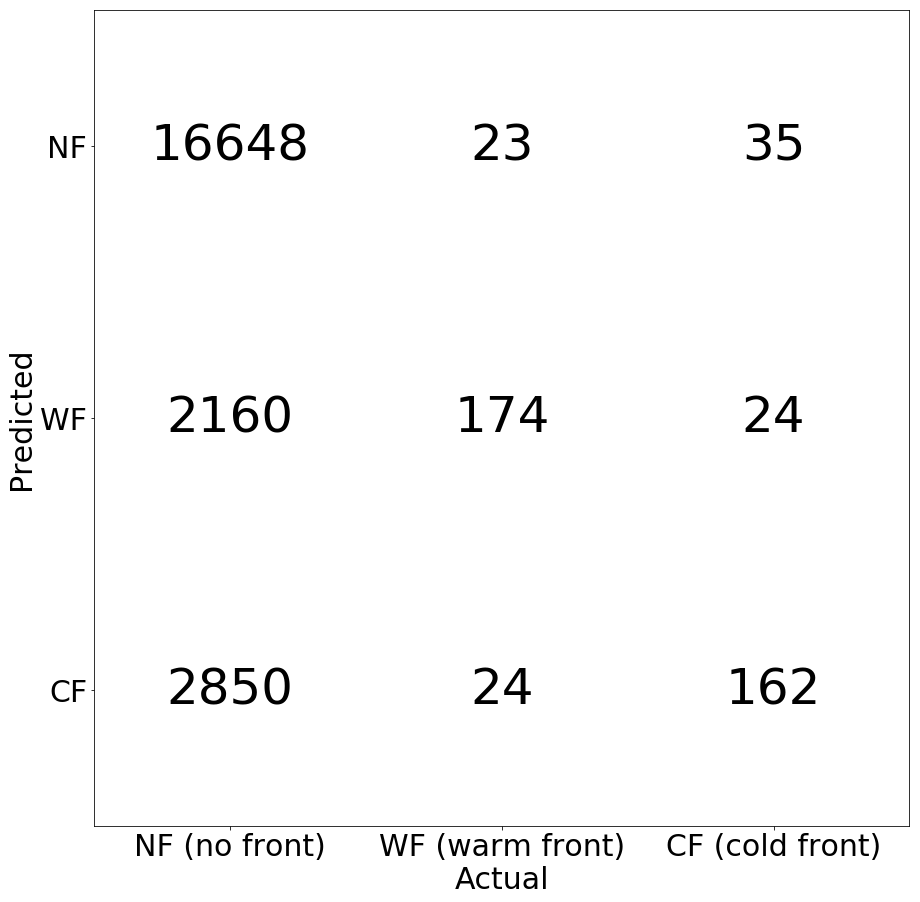

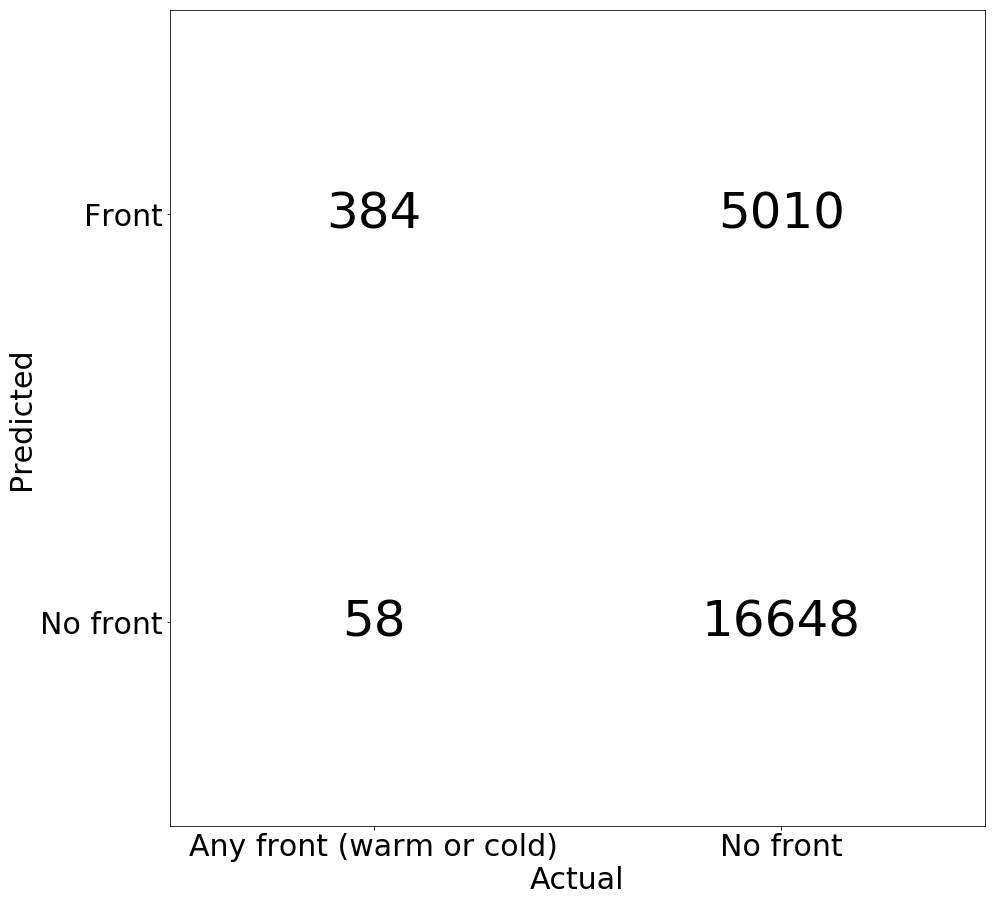

In [30]:
contingency_matrix = eval_utils.get_contingency_table(
    predicted_labels=predicted_labels, observed_labels=target_values,
    num_classes=3)

binary_ct_as_dict = binary_eval.get_contingency_table(
    forecast_labels=(predicted_labels > 0).astype(int),
    observed_labels=(target_values > 0).astype(int))

a = binary_ct_as_dict[binary_eval.NUM_TRUE_POSITIVES_KEY]
b = binary_ct_as_dict[binary_eval.NUM_FALSE_POSITIVES_KEY]
c = binary_ct_as_dict[binary_eval.NUM_FALSE_NEGATIVES_KEY]
d = binary_ct_as_dict[binary_eval.NUM_TRUE_NEGATIVES_KEY]
binary_contingency_matrix = numpy.array([[a, b], [c, d]])

plot_3class_contingency_table(contingency_matrix=contingency_matrix)
plot_2class_contingency_table(contingency_matrix=binary_contingency_matrix)

The following method plots a ROC (receiver operating characteristic) curve for the binary ("front or no front") problem.

In [31]:
def plot_binary_roc_curve(
        class_probability_matrix, target_values, axes_object=None):
    """Plots binary ("front or no front") ROC curve.
    
    :param class_probability_matrix: See doc for `make_predictions`.
    :param target_values: Same.
    :param axes_object: See doc for `plot_feature_map`.
    :return: auc: Area under ROC curve.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    front_probabilities = (
        numpy.sum(class_probability_matrix, axis=1) -
        numpy.sum(class_probability_matrix[:, [NO_FRONT_ENUM]], axis=1)
    )

    pofd_by_threshold, pod_by_threshold = binary_eval.get_points_in_roc_curve(
        forecast_probabilities=front_probabilities,
        observed_labels=(target_values > 0).astype(int), threshold_arg=1001)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    random_x_coords, random_y_coords = binary_eval.get_random_roc_curve()
    random_line_colour = numpy.full(3, 152. / 255)
    actual_line_colour = numpy.array([228, 26, 28], dtype=float) / 255

    axes_object.plot(
        random_x_coords, random_y_coords, color=random_line_colour,
        linestyle='dashed', linewidth=2)

    nan_flags = numpy.logical_or(
        numpy.isnan(pofd_by_threshold), numpy.isnan(pod_by_threshold)
    )
    plot_indices = numpy.where(numpy.invert(nan_flags))[0]
    axes_object.plot(
        pofd_by_threshold[plot_indices], pod_by_threshold[plot_indices],
        color=actual_line_colour, linestyle='solid', linewidth=4)

    axes_object.set_xlabel('POFD (probability of false detection)')
    axes_object.set_ylabel('POD (probability of detection)')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    auc = binary_eval.get_area_under_roc_curve(
        pofd_by_threshold=pofd_by_threshold, pod_by_threshold=pod_by_threshold)
    title_string = 'Area under ROC curve = {0:.4f}'.format(auc)
    axes_object.set_title(title_string)

    return auc, axes_object

The next cell calls plot_binary_roc_curve.

0.9019389342928261

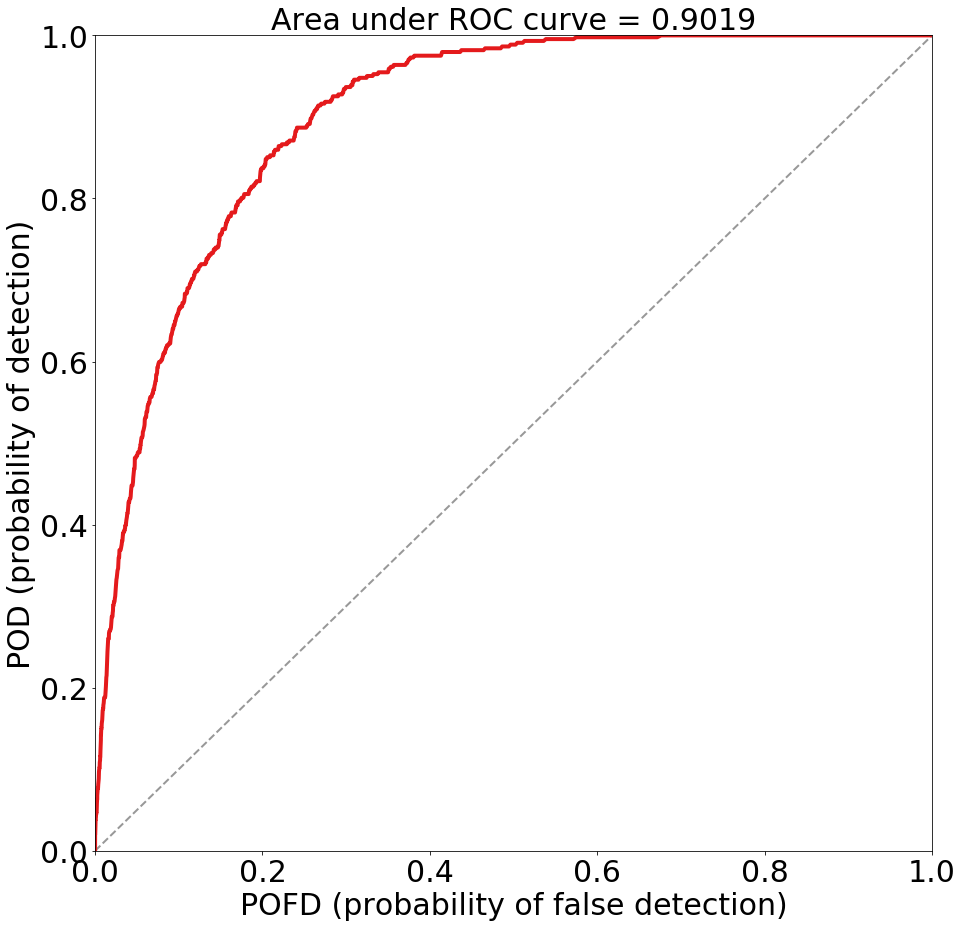

In [32]:
plot_binary_roc_curve(class_probability_matrix=class_probability_matrix,
                      target_values=target_values)

The following methods will be used to plot a performance diagram for the binary ("front or no front") problem.

In [35]:
def _get_csi_colour_scheme():
    """Returns colour scheme for CSI (critical success index).

    :return: colour_map_object: Colour scheme (instance of
        `matplotlib.colors.ListedColormap`).
    :return: colour_norm_object: Instance of `matplotlib.colors.BoundaryNorm`,
        defining the scale of the colour map.
    """

    this_colour_map_object = pyplot.cm.Blues
    this_colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_CSI_CONTOURS, this_colour_map_object.N)

    rgba_matrix = this_colour_map_object(this_colour_norm_object(
        LEVELS_FOR_CSI_CONTOURS))
    colour_list = [
        rgba_matrix[i, ..., :-1] for i in range(rgba_matrix.shape[0])
    ]

    colour_map_object = matplotlib.colors.ListedColormap(colour_list)
    colour_map_object.set_under(numpy.array([1, 1, 1]))
    colour_norm_object = matplotlib.colors.BoundaryNorm(
        LEVELS_FOR_CSI_CONTOURS, colour_map_object.N)

    return colour_map_object, colour_norm_object


def plot_binary_perf_diagram(
        class_probability_matrix, target_values, axes_object=None):
    """Plots binary ("front or no front") performance diagram.

    --- REFERENCE ---

    Roebber, P., 2009: "Visualizing multiple measures of forecast quality."
        Weather and Forecasting, 24 (2), 601-608.

    :param class_probability_matrix: See doc for `make_predictions`.
    :param target_values: Same.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    front_probabilities = (
        numpy.sum(class_probability_matrix, axis=1) -
        numpy.sum(class_probability_matrix[:, [NO_FRONT_ENUM]], axis=1)
    )

    (success_ratio_by_threshold, pod_by_threshold
    ) = binary_eval.get_points_in_performance_diagram(
        forecast_probabilities=front_probabilities,
        observed_labels=(target_values > 0).astype(int), threshold_arg=1001)

    csi_by_threshold = binary_eval.csi_from_sr_and_pod(
        success_ratio_by_threshold, pod_by_threshold)
    max_csi = numpy.nanmax(csi_by_threshold)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    # Compute CSI and frequency-bias grids for background contours.
    success_ratio_matrix, pod_matrix = binary_eval.get_sr_pod_grid()
    csi_matrix = binary_eval.csi_from_sr_and_pod(
        success_ratio_matrix, pod_matrix)
    frequency_bias_matrix = binary_eval.frequency_bias_from_sr_and_pod(
        success_ratio_matrix, pod_matrix)

    # Plot CSI contours.
    colour_map_object, colour_norm_object = _get_csi_colour_scheme()
    pyplot.contourf(
        success_ratio_matrix, pod_matrix, csi_matrix, LEVELS_FOR_CSI_CONTOURS,
        cmap=colour_map_object, norm=colour_norm_object, vmin=0.,
        vmax=1., axes=axes_object)

    colour_bar_object = _add_colour_bar(
        axes_object=axes_object, colour_map_object=colour_map_object,
        values_to_colour=csi_matrix, min_colour_value=0.,
        max_colour_value=1., colour_norm_object=colour_norm_object,
        orientation_string='vertical', extend_min=False, extend_max=False)
    colour_bar_object.set_label('CSI (critical success index)')

    # Plot frequency-bias contours.
    bias_colour = numpy.full(3, 152. / 255)
    bias_colour_tuple = ()
    for _ in range(len(LEVELS_FOR_BIAS_CONTOURS)):
        bias_colour_tuple += (bias_colour,)

    bias_contour_object = pyplot.contour(
        success_ratio_matrix, pod_matrix, frequency_bias_matrix,
        LEVELS_FOR_BIAS_CONTOURS, colors=bias_colour_tuple,
        linewidths=2, linestyles='dashed', axes=axes_object)
    pyplot.clabel(
        bias_contour_object, inline=True, inline_spacing=10, fmt='%.2f',
        fontsize=FONT_SIZE)

    # Plot the actual curve.
    nan_flags = numpy.logical_or(
        numpy.isnan(success_ratio_by_threshold), numpy.isnan(pod_by_threshold)
    )
    plot_indices = numpy.where(numpy.invert(nan_flags))[0]

    actual_line_colour = numpy.array([228, 26, 28], dtype=float) / 255
    axes_object.plot(
        success_ratio_by_threshold[plot_indices],
        pod_by_threshold[plot_indices],
        color=actual_line_colour, linestyle='solid', linewidth=4)

    axes_object.set_xlabel('Success ratio (1 - FAR)')
    axes_object.set_ylabel('POD (probability of detection)')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    title_string = 'Max CSI = {0:.4f}'.format(max_csi)
    axes_object.set_title(title_string)
    
    return axes_object

The next cell calls plot_binary_perf_diagram.

/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:543: RuntimeWarning: invalid value encountered in less
  if numpy.any(input_variable < base_value):
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/error_checking.py:591: RuntimeWarning: invalid value encountered in greater
  if numpy.any(input_variable > base_value):
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/GewitterGefahr-0.1-py2.7.egg/gewittergefahr/gg_utils/model_evaluation.py:1103: RuntimeWarning: divide by zero encountered in reciprocal
  return (success_ratio_array ** -1 + pod_array ** -1 - 1.) ** -1
/home/ryan.lagerquist/anaconda2_general_exam/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'axes'
  s)


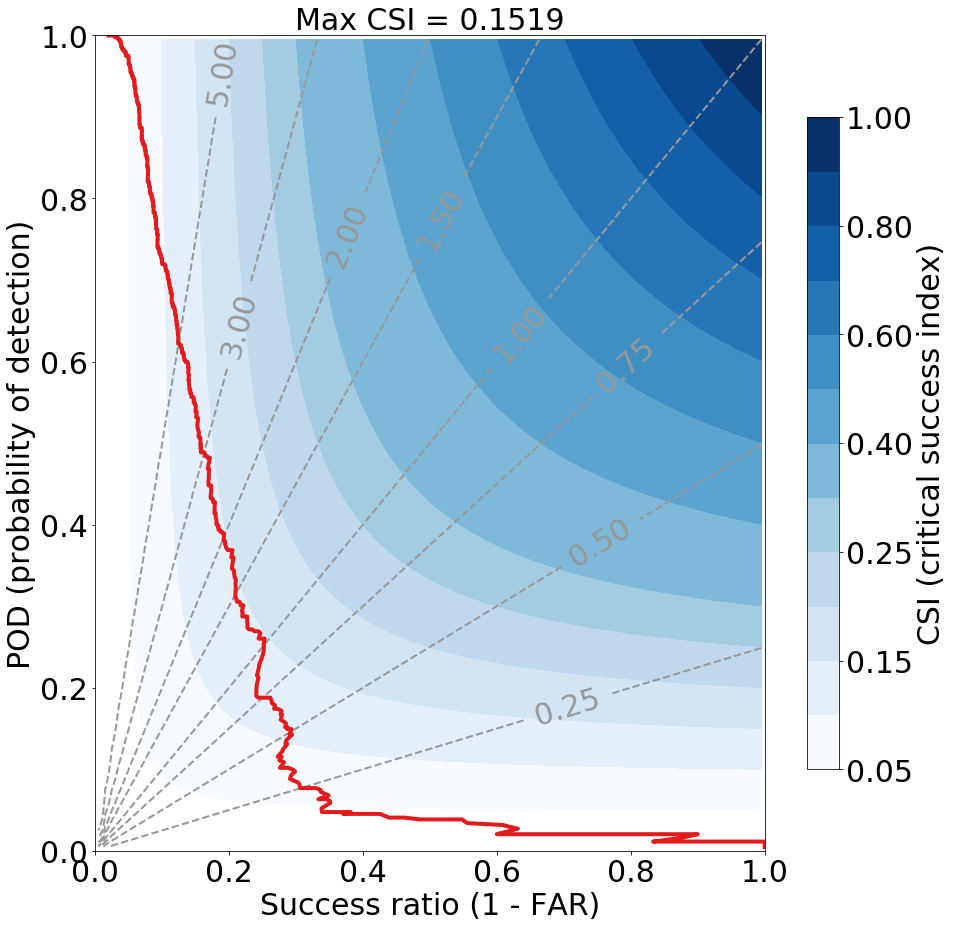

In [34]:
plot_binary_perf_diagram(class_probability_matrix=class_probability_matrix,
                         target_values=target_values)

The following method will be used to plot a reliability curve for the binary ("front or no front") problem.  Reliability curves are a good complement to ROC curves and performance diagrams, because they plot probabilistic, rather than deterministic, predictions.

In [36]:
def plot_binary_relia_curve(
        class_probability_matrix, target_values, axes_object=None):
    """Plots binary ("front or no front") reliability curve.

    --- REFERENCE ---

    Hsu, W., and A. Murphy, 1986: "The attributes diagram: A geometrical
        framework for assessing the quality of probability forecasts."
        International Journal of Forecasting, 2 (3), 285-293.

    :param class_probability_matrix: See doc for `make_predictions`.
    :param target_values: Same.
    :param axes_object: See doc for `plot_feature_map`.
    :return: axes_object: See doc for `plot_feature_map`.
    """

    front_probabilities = (
        numpy.sum(class_probability_matrix, axis=1) -
        numpy.sum(class_probability_matrix[:, [NO_FRONT_ENUM]], axis=1)
    )

    (mean_front_prob_by_bin, front_frequency_by_bin, _
    ) = binary_eval.get_points_in_reliability_curve(
        forecast_probabilities=front_probabilities,
        observed_labels=(target_values > 0).astype(int),
        num_forecast_bins=20)

    if axes_object is None:
        _, axes_object = pyplot.subplots(
            1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES))

    (perfect_x_coords, perfect_y_coords
     ) = binary_eval.get_perfect_reliability_curve()
    perfect_line_colour = numpy.full(3, 152. / 255)
    actual_line_colour = numpy.array([228, 26, 28], dtype=float) / 255

    axes_object.plot(
        perfect_x_coords, perfect_y_coords, color=perfect_line_colour,
        linestyle='dashed', linewidth=2)

    nan_flags = numpy.logical_or(
        numpy.isnan(mean_front_prob_by_bin), numpy.isnan(front_frequency_by_bin)
    )
    plot_indices = numpy.where(numpy.invert(nan_flags))[0]
    axes_object.plot(
        mean_front_prob_by_bin[plot_indices],
        front_frequency_by_bin[plot_indices],
        color=actual_line_colour, linestyle='solid', linewidth=4)

    axes_object.set_xlabel('Predicted front probability')
    axes_object.set_ylabel('Conditional front frequency')
    axes_object.set_xlim(0., 1.)
    axes_object.set_ylim(0., 1.)

    return axes_object

The next cell calls _plot_binary_relia_curve.

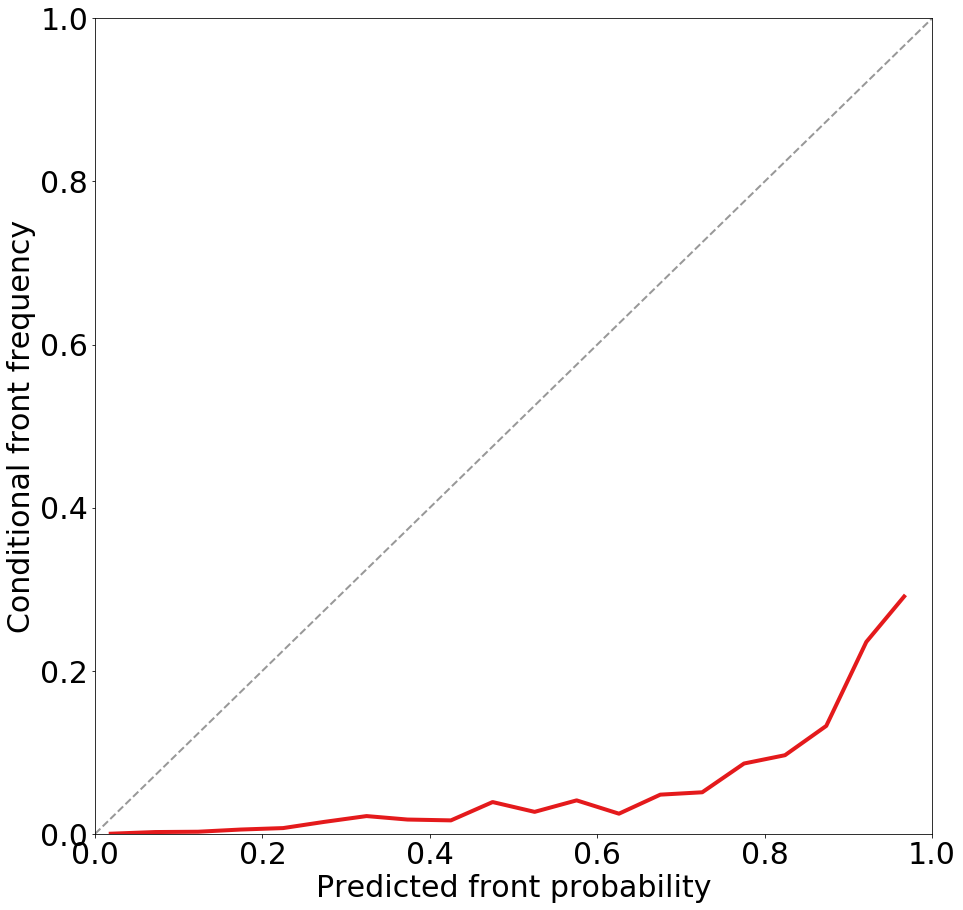

In [37]:
plot_binary_relia_curve(class_probability_matrix=class_probability_matrix,
                        target_values=target_values)

For each predictor variable x, the next cell plots the ROC curve obtained by permuting x.  Lower AUC values mean that permuting x has a greater effect.  Thus, the variable with the lowest AUC below is the "best" predictor, according to this test, because permuting it decreases AUC the most.  The "worst" predictor, according to this test, is the one with the highest AUC (permuting it has the least effect).

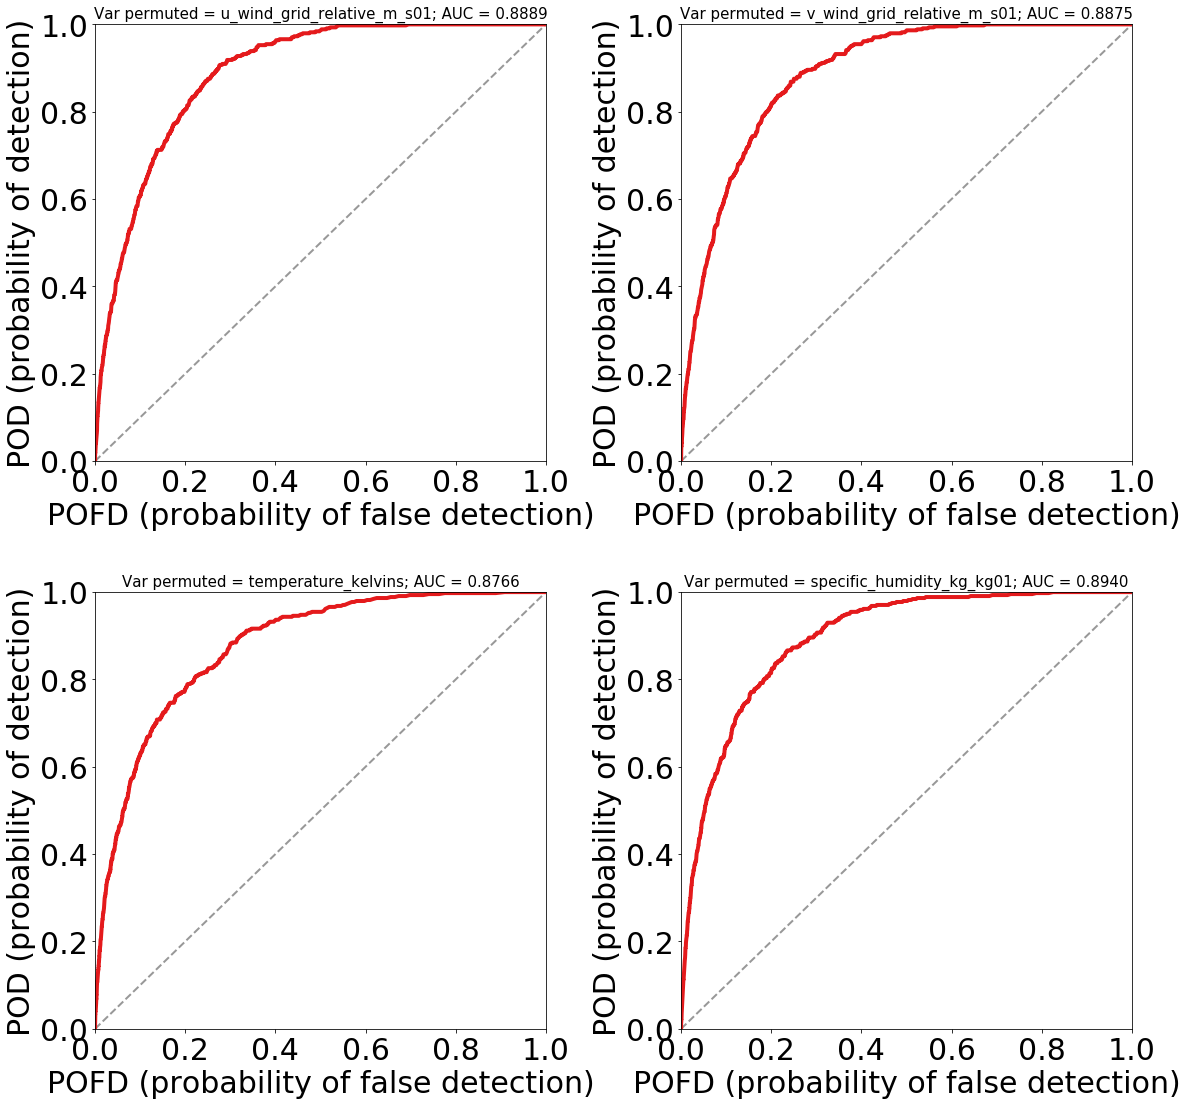

In [39]:
num_predictors = len(predictor_names_to_keep)
num_panel_rows = 2
num_panel_columns = int(numpy.ceil(float(num_predictors) / num_panel_rows))

_, axes_objects_2d_list = _init_figure_panels(
    num_rows=num_panel_rows, num_columns=num_panel_columns,
    horizontal_space_fraction=0.3, vertical_space_fraction=0.3)

for m in range(num_predictors):
    this_panel_row, this_panel_column = numpy.unravel_index(
        m, (num_panel_rows, num_panel_columns))

    this_auc = plot_binary_roc_curve(
        class_probability_matrix=permuted_probability_matrix[..., m],
        target_values=target_values,
        axes_object=axes_objects_2d_list[this_panel_row][this_panel_column]
    )

    this_title_string = 'Var permuted = {0:s}; AUC = {1:.4f}'.format(
        predictor_names_to_keep[m], this_auc)
    axes_objects_2d_list[this_panel_row][this_panel_column].set_title(
        this_title_string, fontsize=15)

The following method computes a saliency map for each example, according to one CNN.

In [40]:
def get_saliency_maps(model_object, target_class, predictor_matrix):
    """Computes saliency map for each example in `predictor_matrix`.

    "Saliency" is defined for each predictor variable x at each grid cell
    [i, j].  The saliency of x[i, j] is the gradient of the CNN's prediction
    (probability of `target_class`) with respect to x[i, j].  Both large
    positive and large negative saliency values mean that x[i, j] is important
    (has a large influence on the prediction).

    :param model_object: Trained CNN (instance of `keras.models`).  Saliency
        will be computed for this CNN only.  Different models give different
        answers.
    :param target_class: Target class (integer).  Possible values are
        `NO_FRONT_ENUM`, `WARM_FRONT_ENUM`, and `WARM_FRONT_ENUM`, listed at the
        top of this notebook.
    :param predictor_matrix: E-by-M-by-N-by-C numpy array of predictor values.
    :return: saliency_matrix: E-by-M-by-N-by-C numpy array of saliency values.
    """

    loss_tensor = K.mean(
        (model_object.layers[-1].output[..., target_class] - 1) ** 2)

    gradient_tensor = K.gradients(loss_tensor, [model_object.input])[0]
    gradient_tensor = gradient_tensor / K.maximum(
        K.std(gradient_tensor), K.epsilon()
    )

    inputs_to_gradients_function = K.function(
        [model_object.input, K.learning_phase()], [gradient_tensor])

    saliency_matrix = inputs_to_gradients_function([predictor_matrix, 0])[0]
    return -1 * saliency_matrix

The following method plots the predictors and saliency map for one example.

In [41]:
def plot_saliency_one_example(
        predictor_matrix, saliency_matrix, predictor_names):
    """Plots saliency maps for one example.
    
    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param saliency_matrix: M-by-N-by-C numpy array of saliency values.
    :param predictor_names: length-C list of predictor variables.
    """

    max_saliency = numpy.percentile(numpy.absolute(saliency_matrix), 99.)
    min_saliency = -1 * max_saliency
    saliency_contour_levels = numpy.linspace(
        min_saliency, max_saliency, num=21, dtype=float)

    num_predictors = len(predictor_names)
    num_panel_rows = 2
    num_panel_columns = int(numpy.ceil(float(num_predictors) / num_panel_rows))

    _, axes_objects_2d_list = _init_figure_panels(
        num_rows=num_panel_rows, num_columns=num_panel_columns,
        horizontal_space_fraction=0.15, vertical_space_fraction=0.15)

    for m in range(num_predictors):
        this_panel_row, this_panel_column = numpy.unravel_index(
            m, (num_panel_rows, num_panel_columns))
        plot_feature_map(
            feature_matrix=predictor_matrix[..., m],
            axes_object=axes_objects_2d_list[this_panel_row][this_panel_column],
            colour_map_object=pyplot.cm.Oranges)

        axes_objects_2d_list[this_panel_row][this_panel_column].contour(
            saliency_matrix[..., m], saliency_contour_levels,
            cmap=pyplot.cm.PRGn, vmin=min_saliency, vmax=max_saliency,
            linewidths=4, linestyles='solid')

        this_title_string = 'Saliency for {0:s}'.format(predictor_names[m])
        axes_objects_2d_list[this_panel_row][this_panel_column].set_title(
            this_title_string, fontsize=20)

The next cell plots a WF saliency map, containing the saliency with respect to warm-front probability, for an NF testing example (where the true label is "no front").

Reading data from: "/localdata/ryan.lagerquist/general_exam/narr_data/downsized_3d_examples/testing/downsized_3d_examples_2017020100-2017020121.nc"...


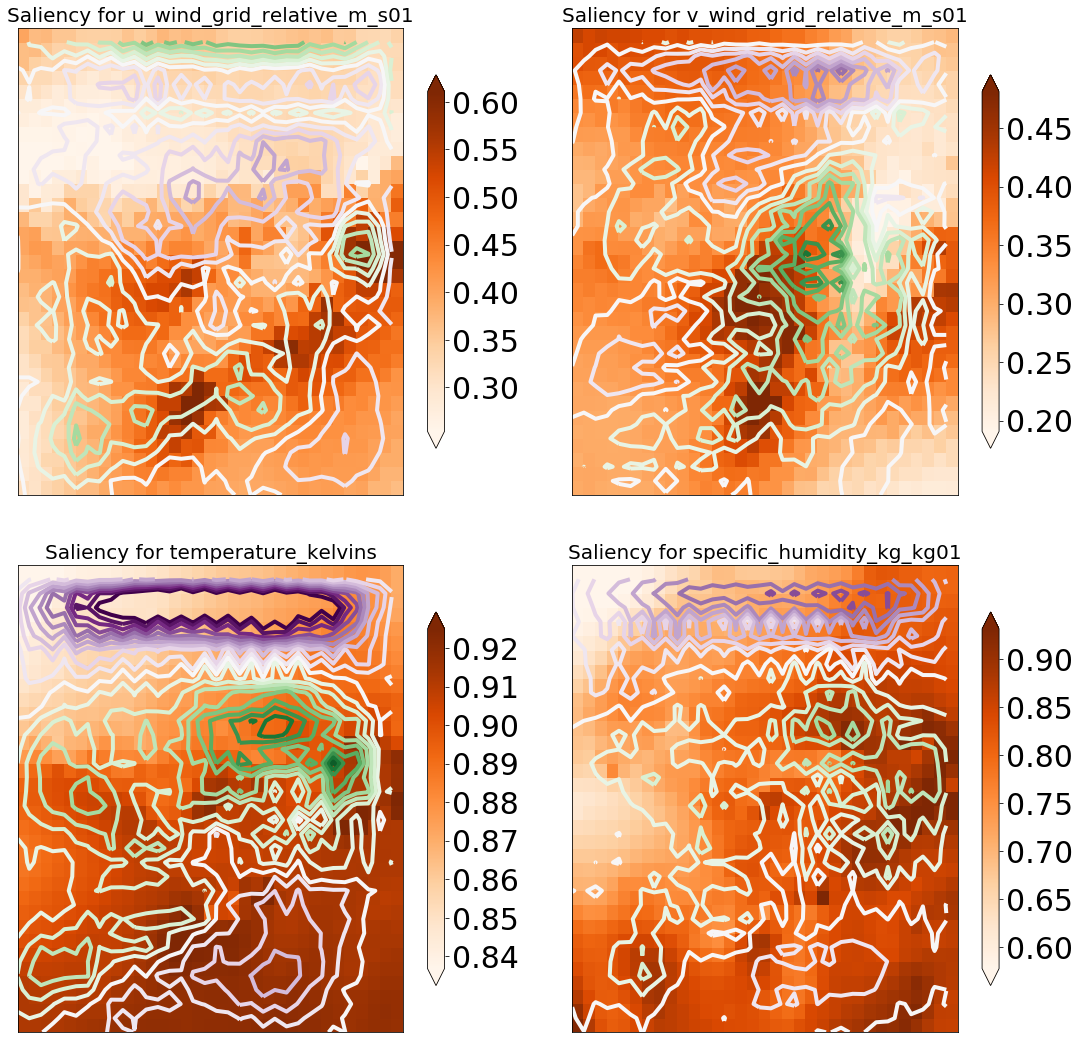

In [42]:
input_dimensions = numpy.array(
    best_model_object.layers[0].input.get_shape().as_list()[1:], dtype=int)

num_grid_rows = input_dimensions[0]
num_half_rows = (num_grid_rows - 1) / 2
num_grid_columns = input_dimensions[1]
num_half_columns = (num_grid_columns - 1) / 2

print 'Reading data from: "{0:s}"...'.format(testing_file_names[0])
example_dict = read_input_examples(
    netcdf_file_name=testing_file_names[0],
    predictor_names_to_keep=predictor_names_to_keep,
    num_half_rows_to_keep=num_half_rows,
    num_half_columns_to_keep=num_half_columns)

no_front_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, NO_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][no_front_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object, target_class=WARM_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)

The next cell plots the CF saliency map for the same example.

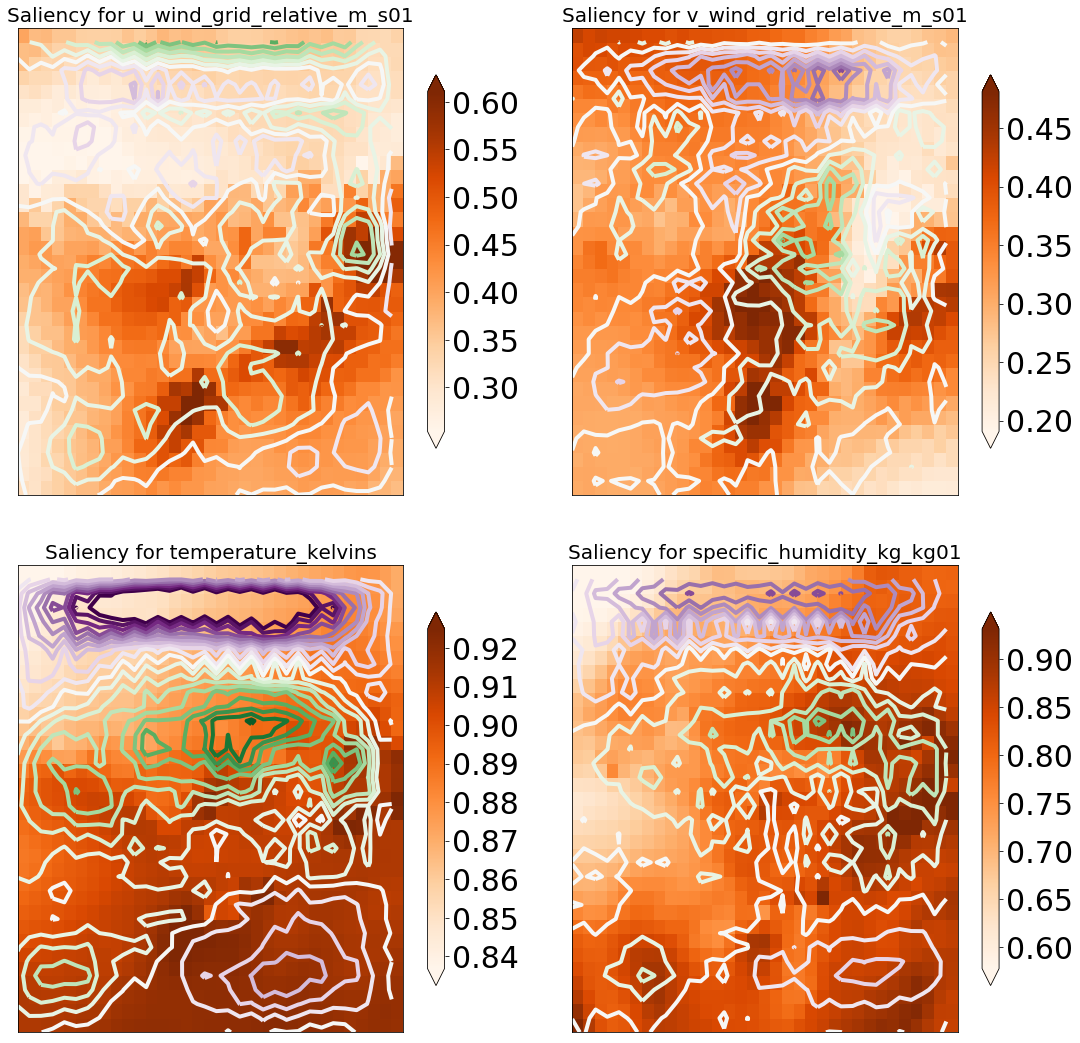

In [43]:
saliency_matrix = get_saliency_maps(
    model_object=best_model_object,
    target_class=COLD_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)

The next cell plots the CF saliency map for a CF example.

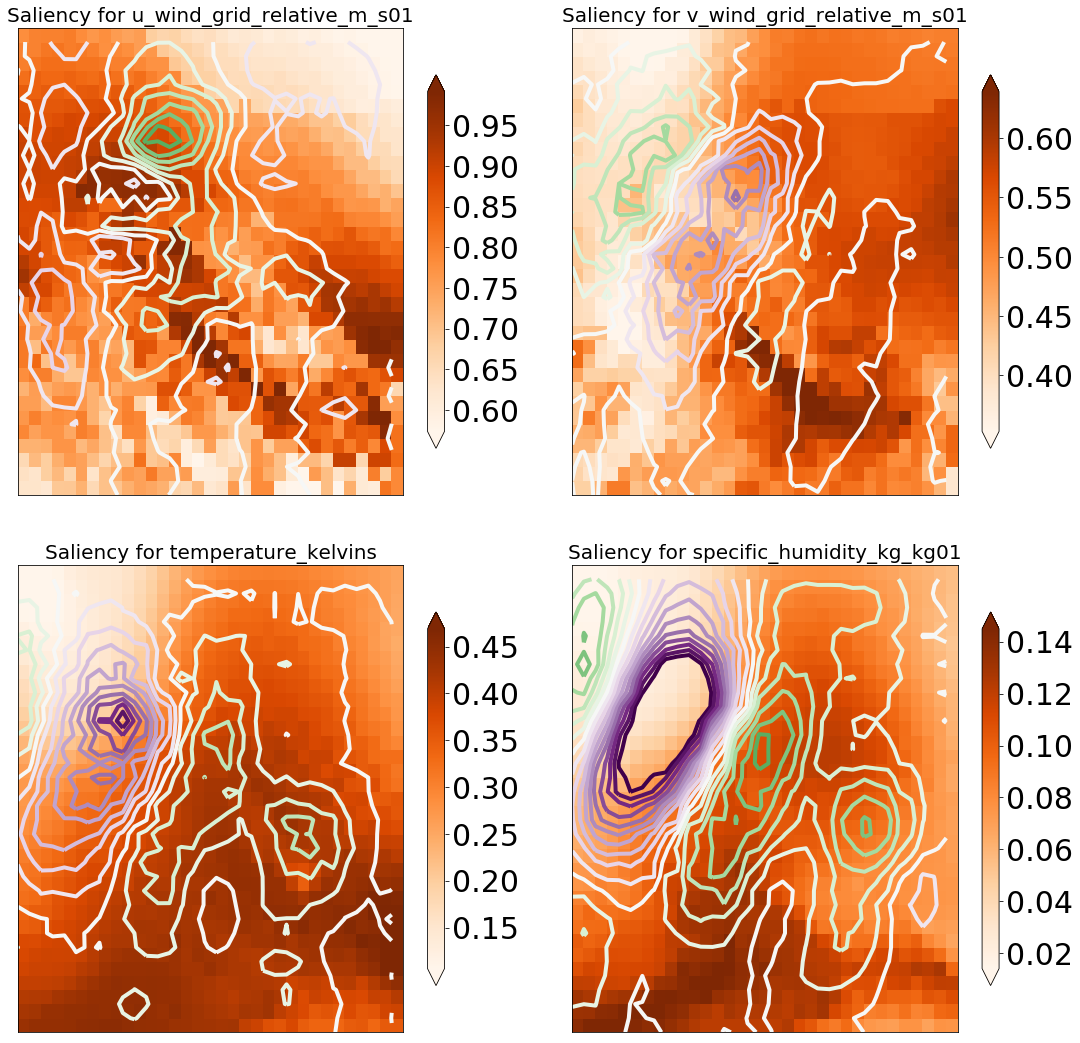

In [44]:
cold_front_index = numpy.where(
    example_dict[TARGET_MATRIX_KEY][:, COLD_FRONT_ENUM] == 1
)[0][0]
predictor_matrix = example_dict[PREDICTOR_MATRIX_KEY][cold_front_index, ...]

saliency_matrix = get_saliency_maps(
    model_object=best_model_object,
    target_class=COLD_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)

The next cell plots WF saliency for the same CF example.

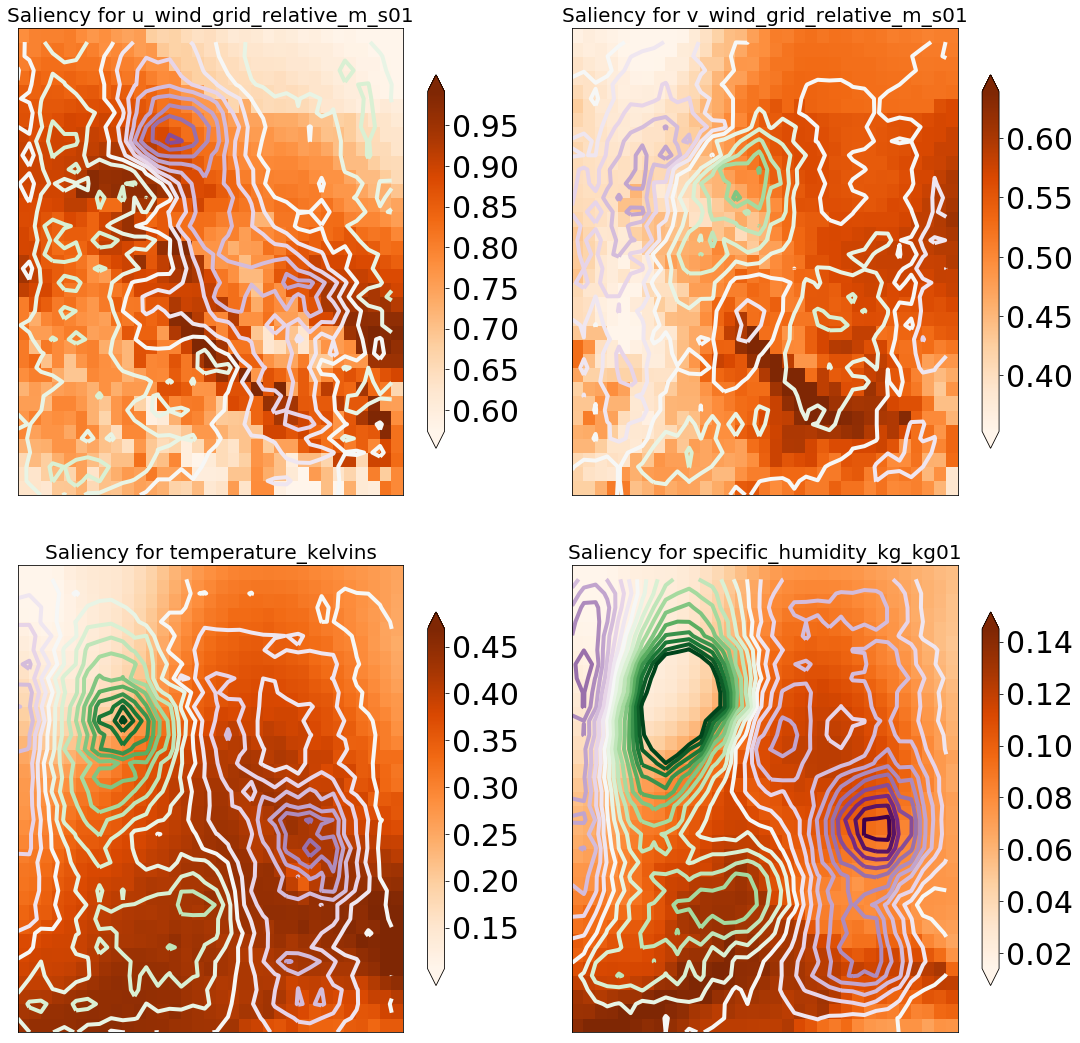

In [45]:
saliency_matrix = get_saliency_maps(
    model_object=best_model_object,
    target_class=WARM_FRONT_ENUM,
    predictor_matrix=numpy.expand_dims(predictor_matrix, axis=0)
)
saliency_matrix = saliency_matrix[0, ...]

plot_saliency_one_example(
    predictor_matrix=predictor_matrix,
    saliency_matrix=saliency_matrix,
    predictor_names=predictor_names_to_keep)